In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# SMD

In [ ]:
# download dataset


In [10]:
from sklearn.preprocessing import StandardScaler
from anomaly_detection.data_factory.dataset import get_dataset_v2

def load_SMD():
    dataset = "SMD"
    data_path = f"./dataset/{dataset}"
    scaler_class = StandardScaler
    return get_dataset_v2(data_path, dataset, scaler_class)


## Visualization

In [2]:
SMD_dataset_loader = load_SMD()

SMD_dataset_loader.describe()

(708405, 38)
train shape: (708405, 38)
test shape: (708420, 38)
test labels shape: (708420,)


kpi_num:  38


/tmp/ipykernel_438579/34815273.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(20, 8))


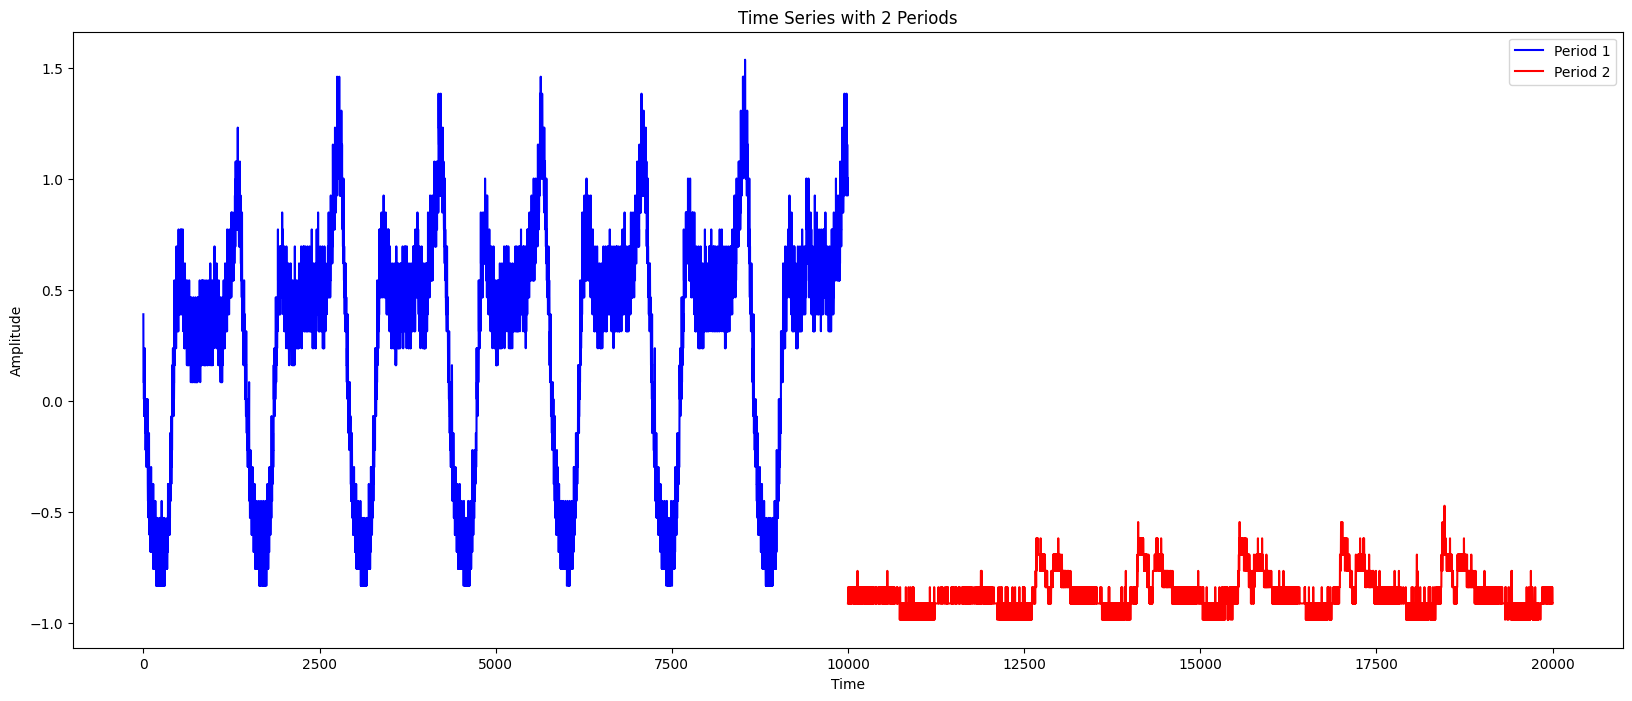

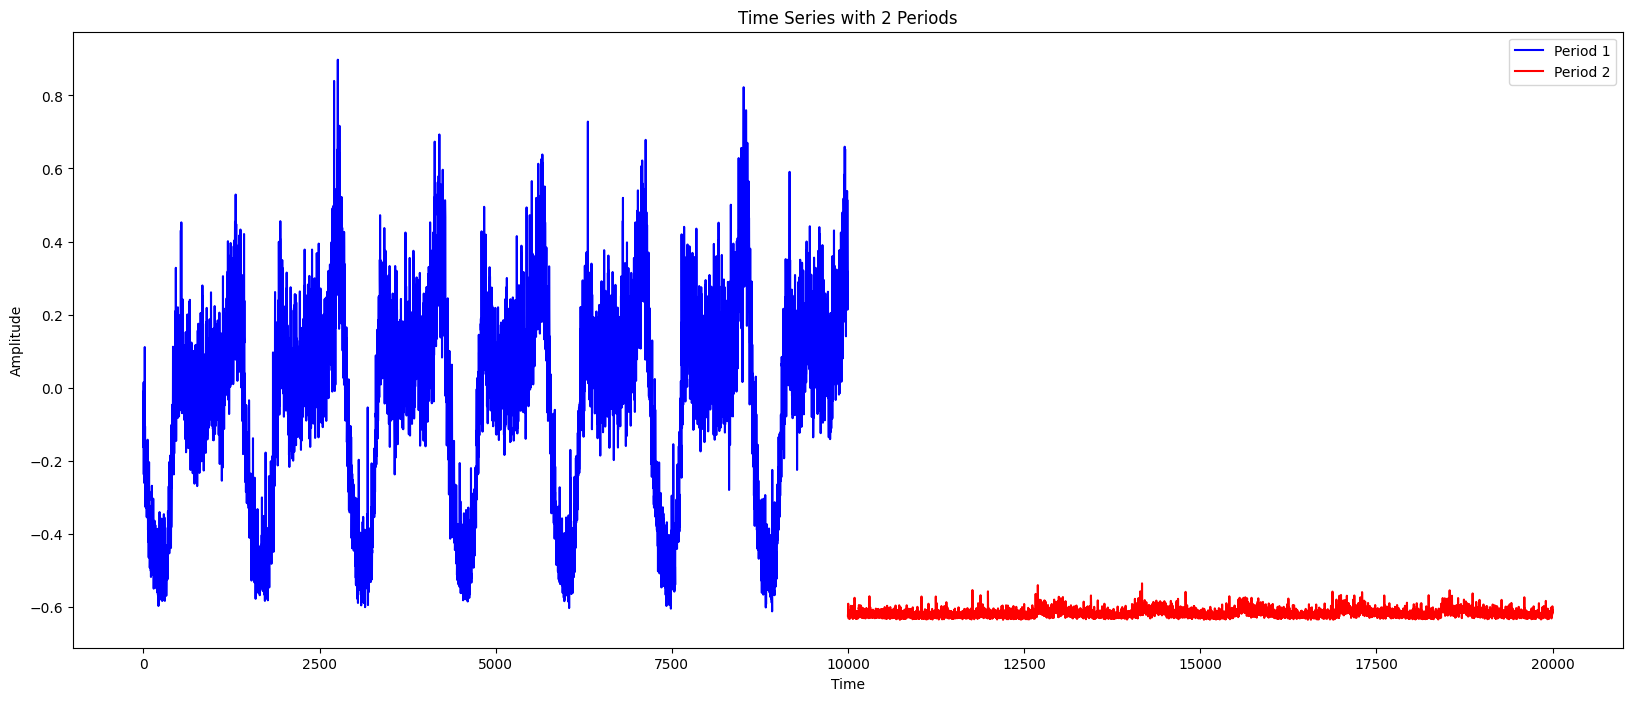

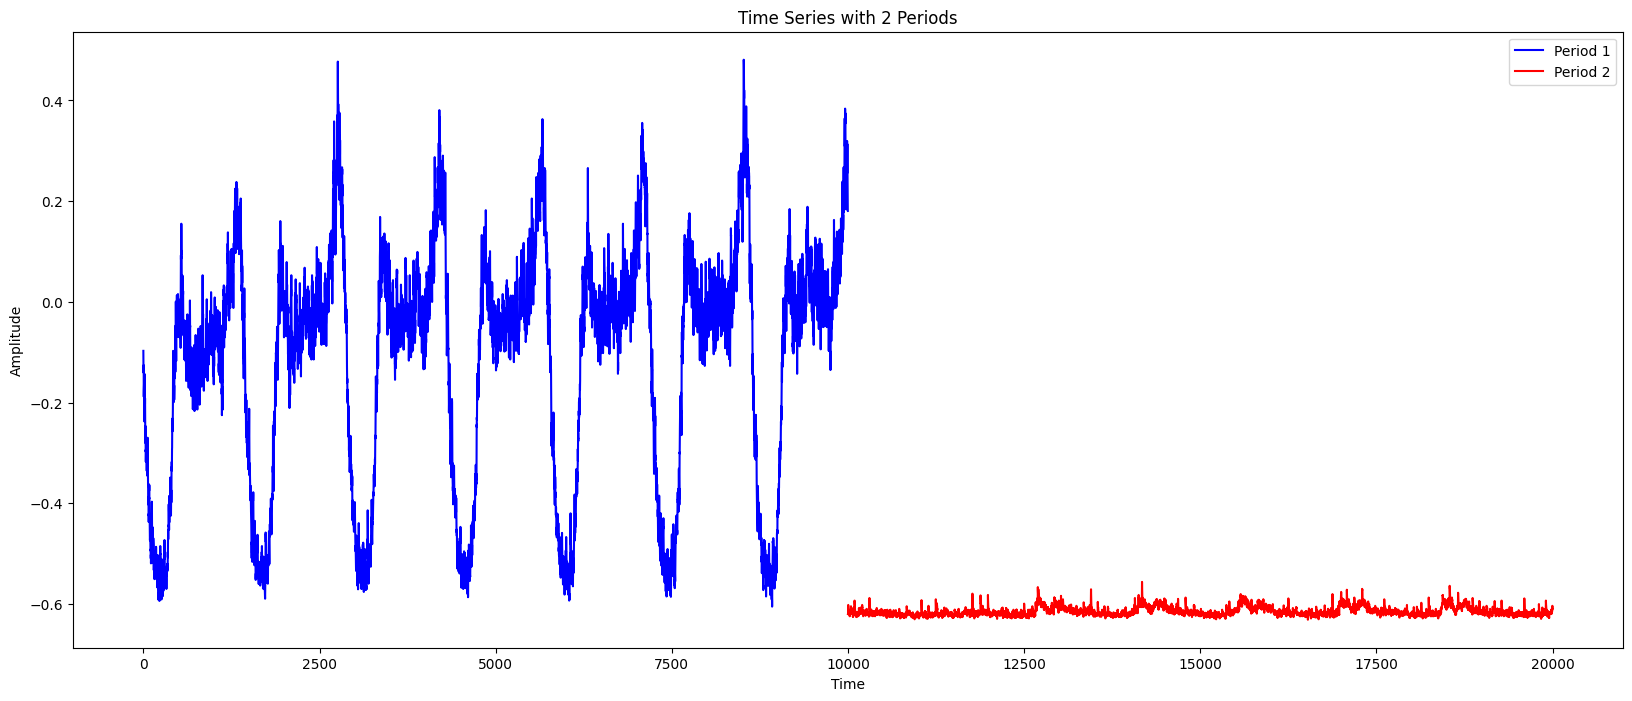

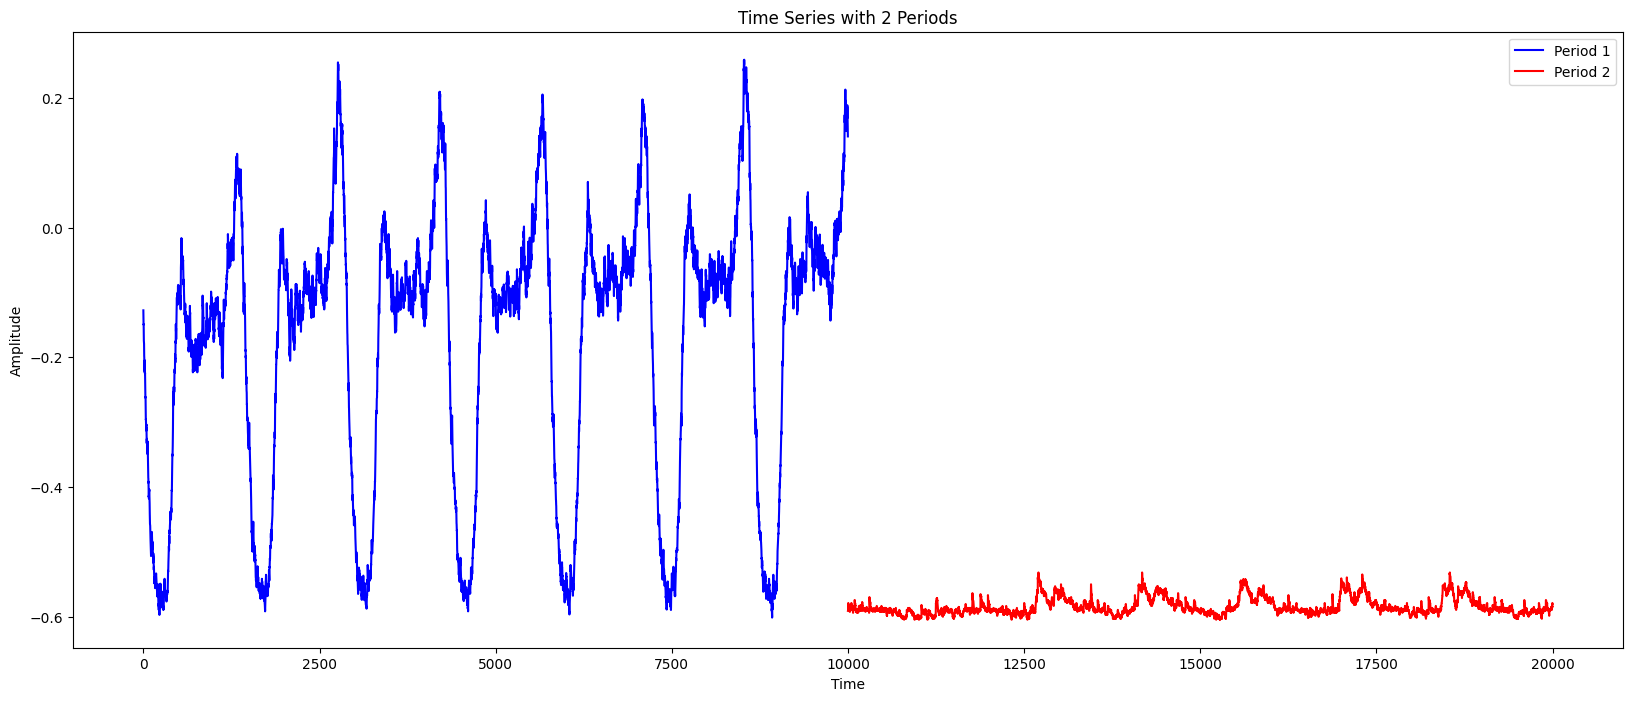

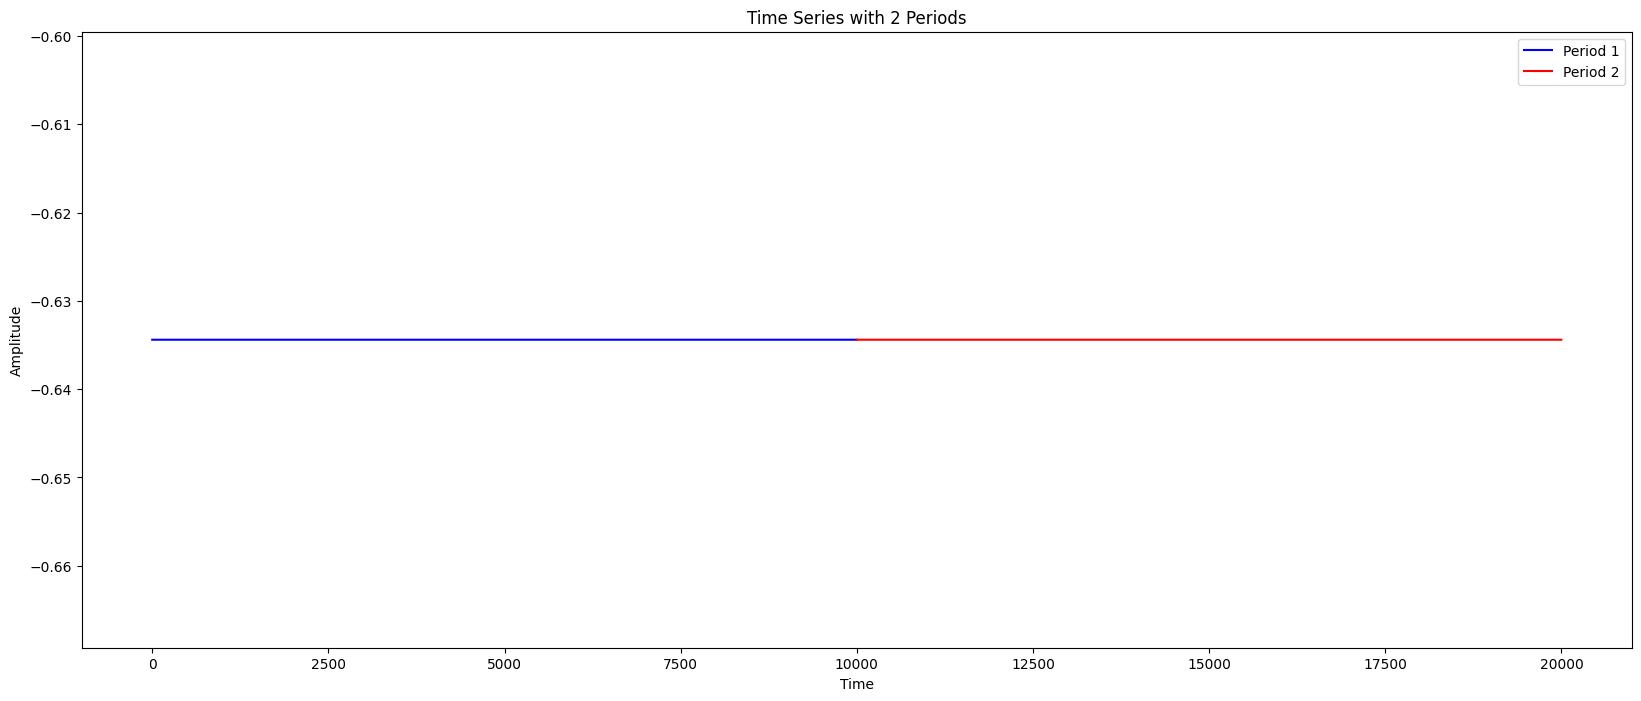

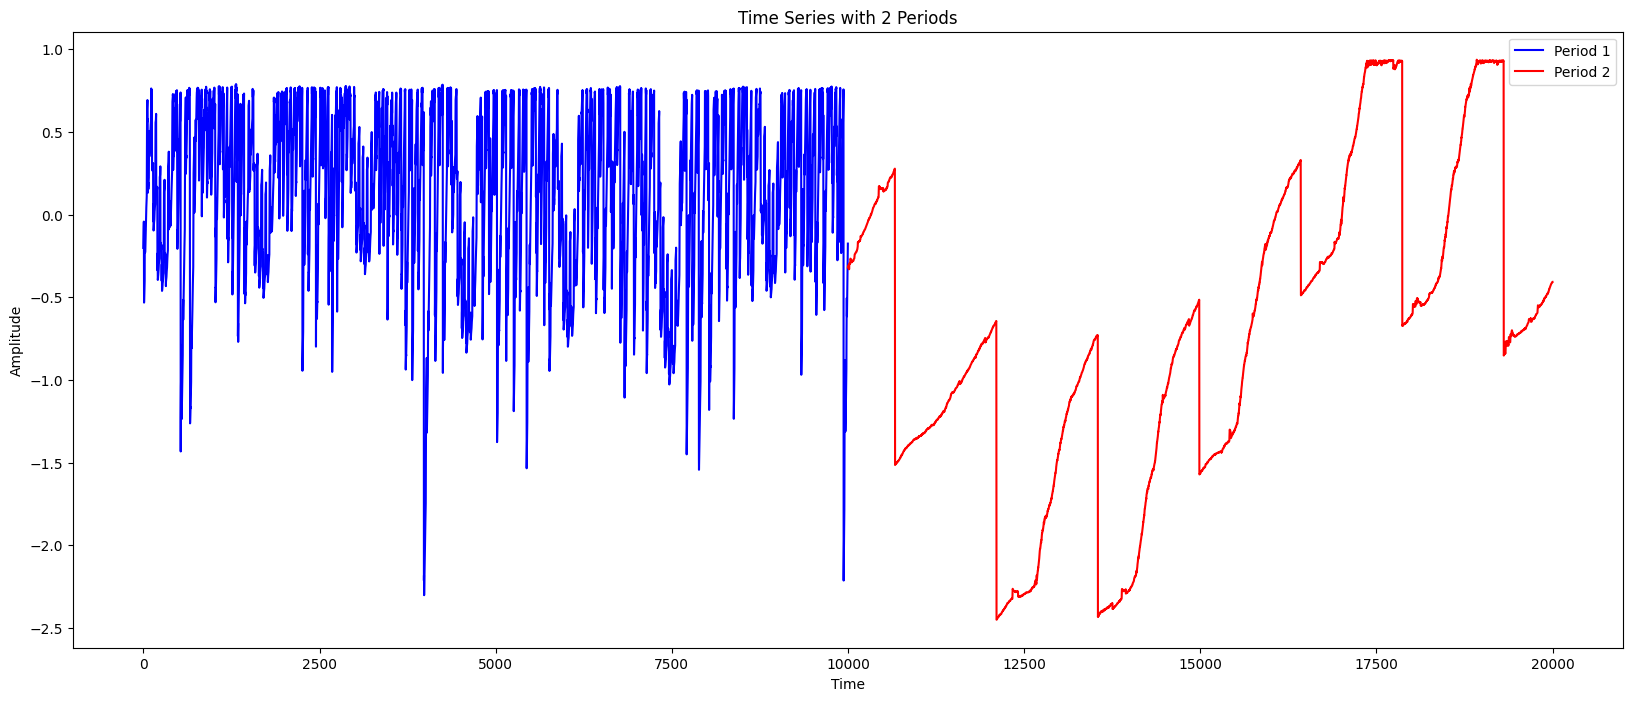

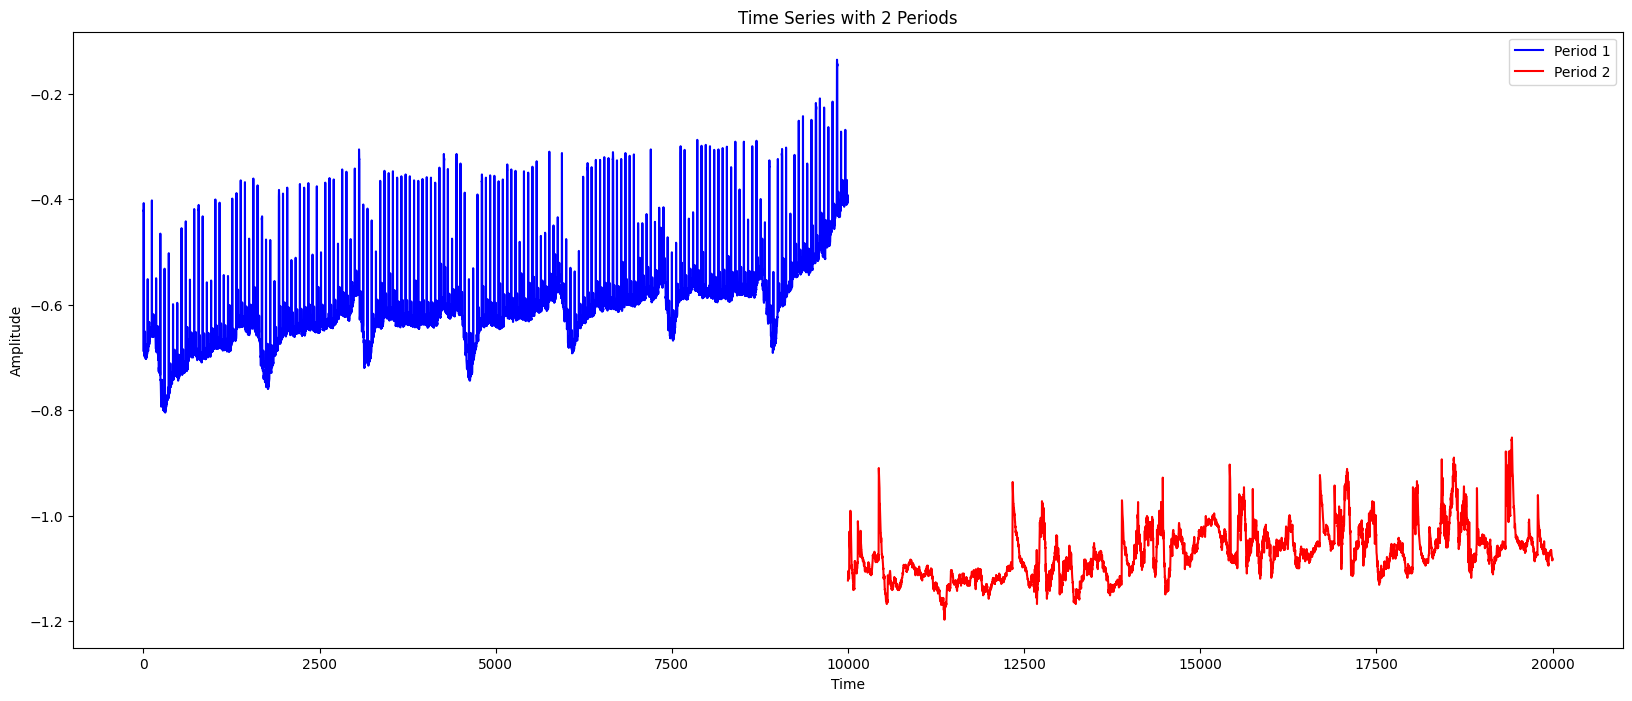

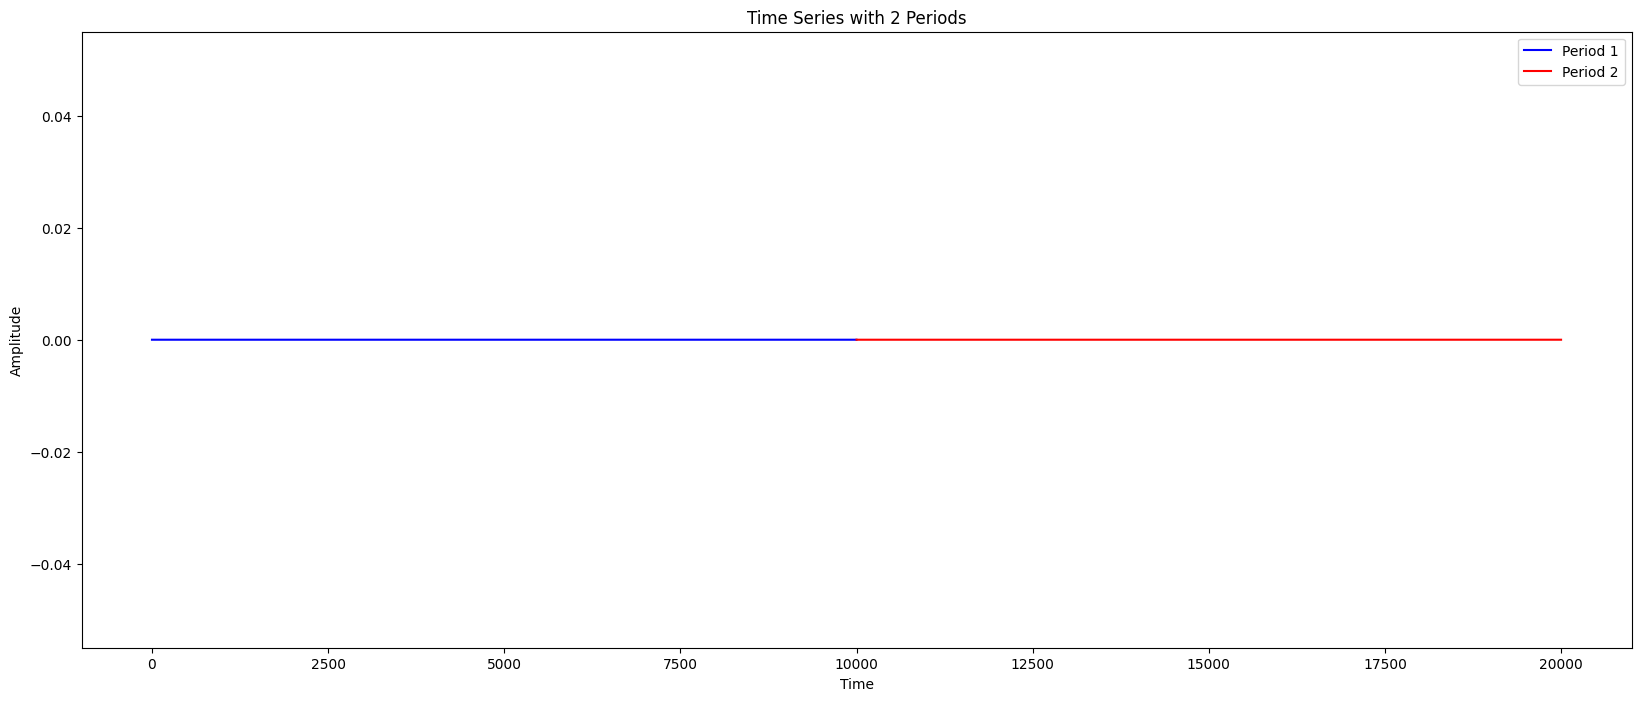

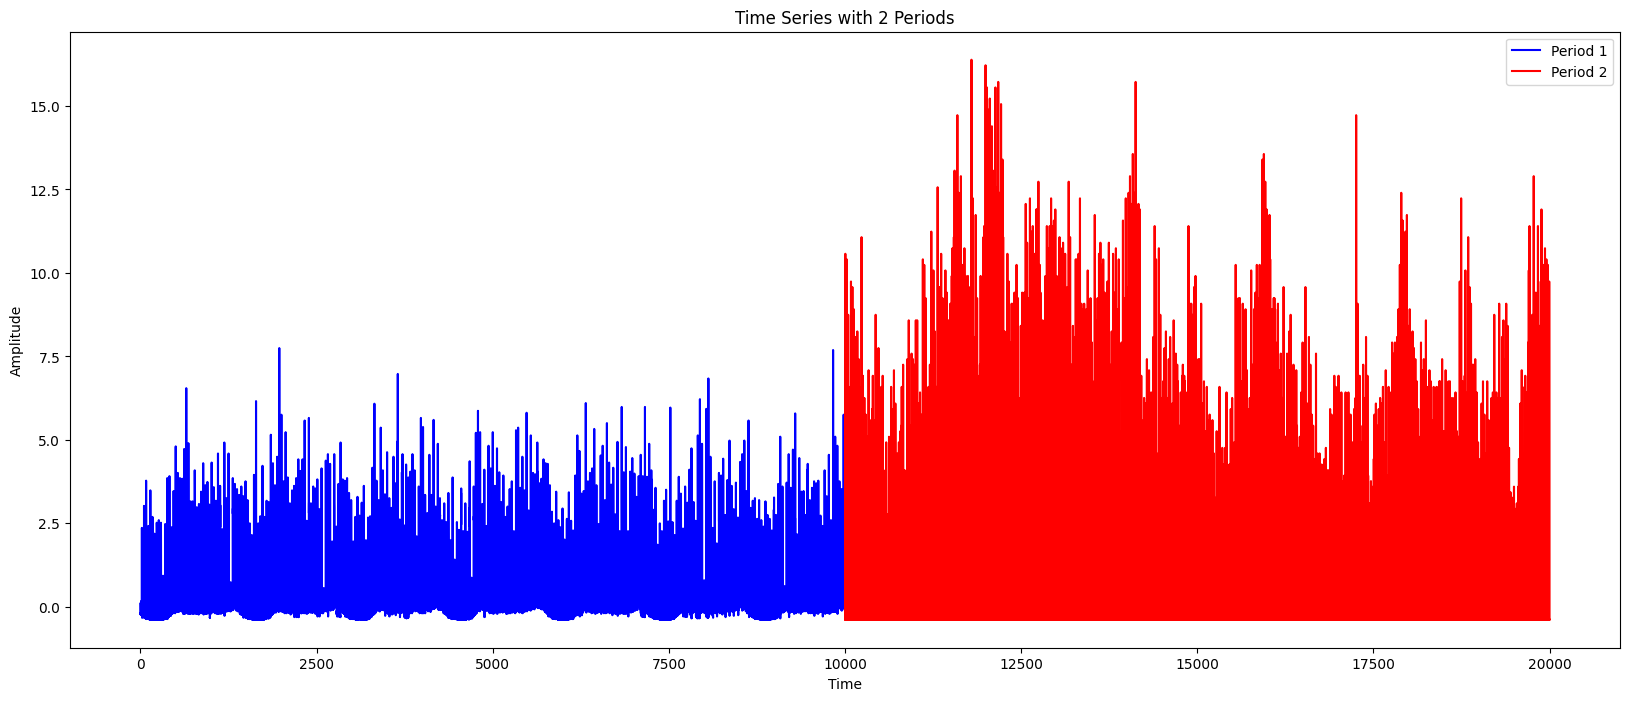

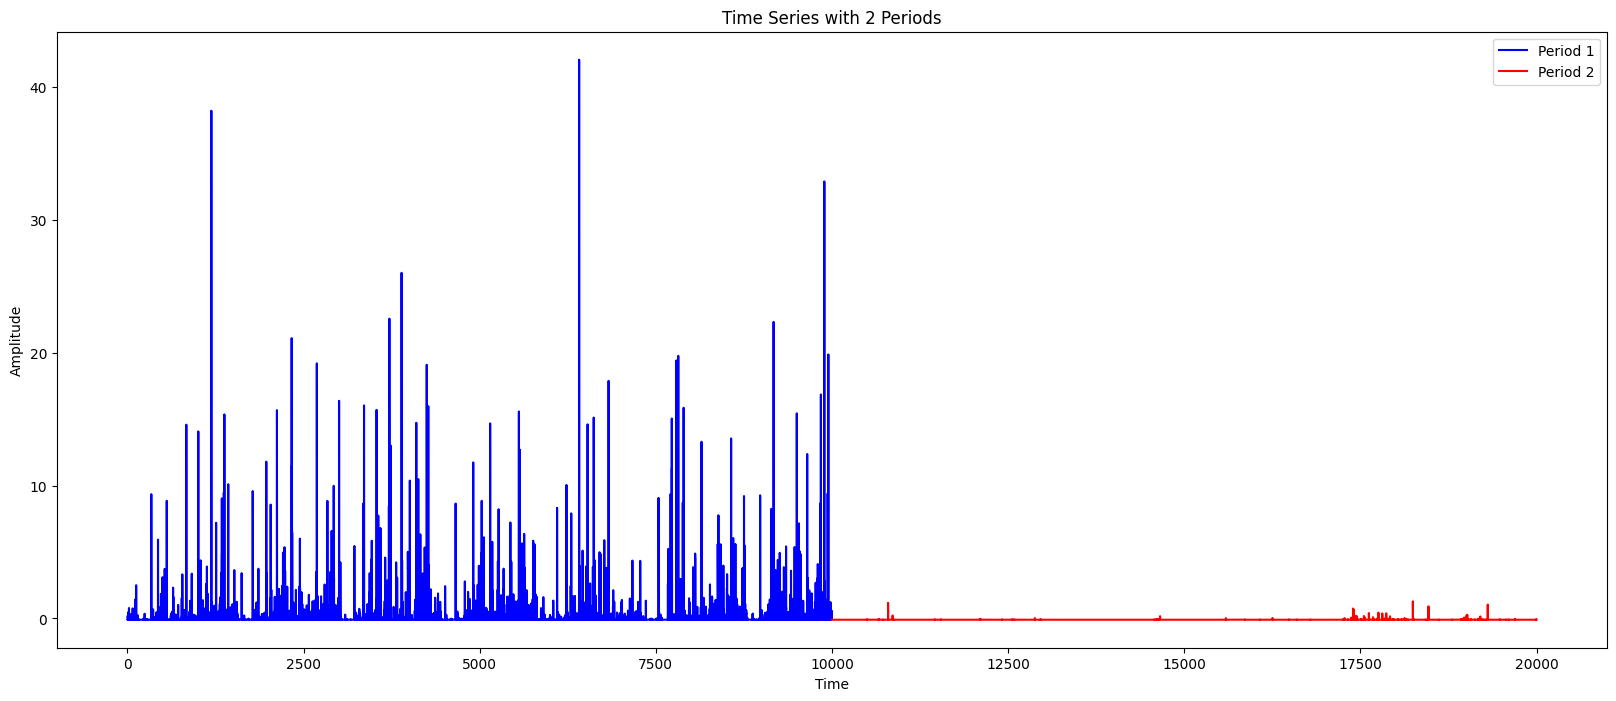

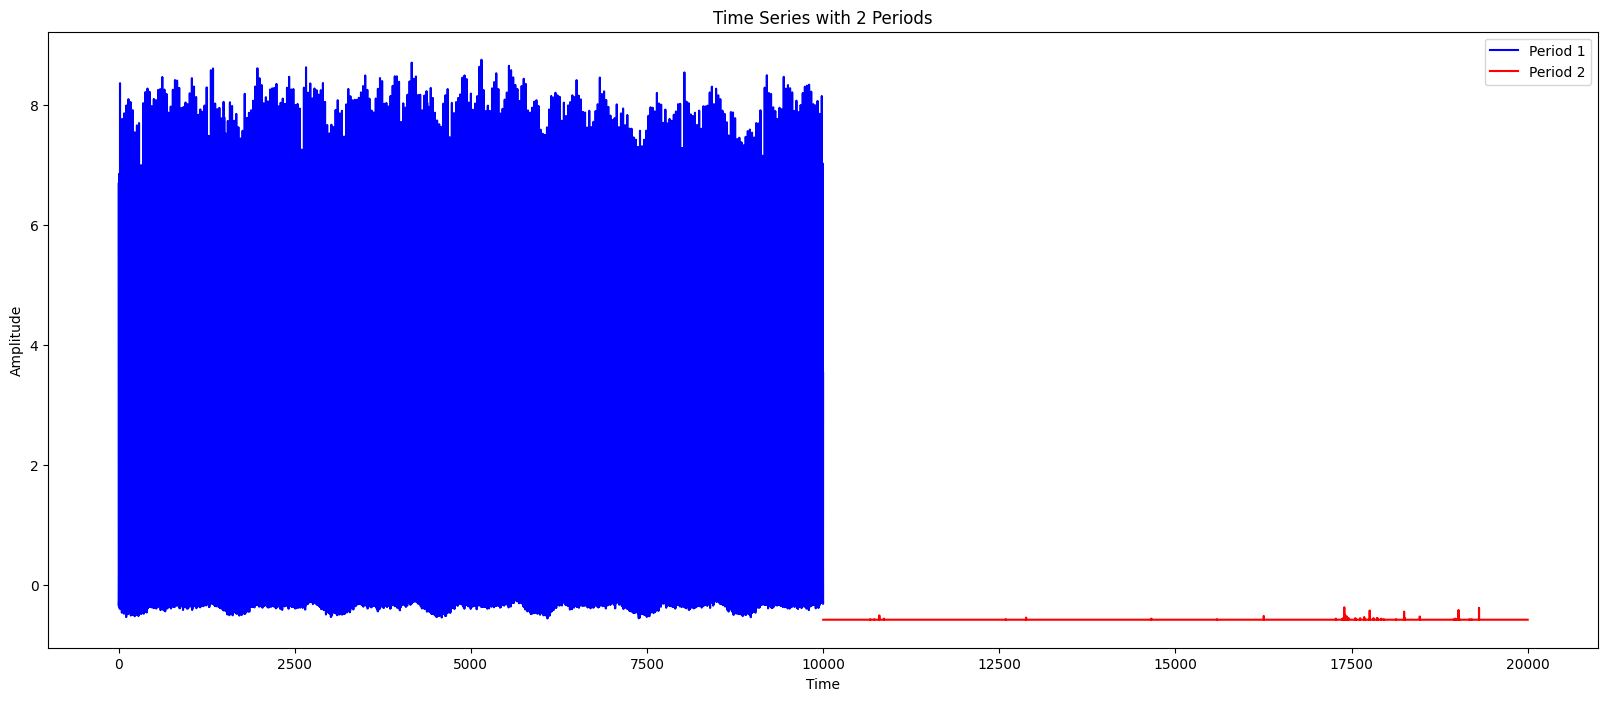

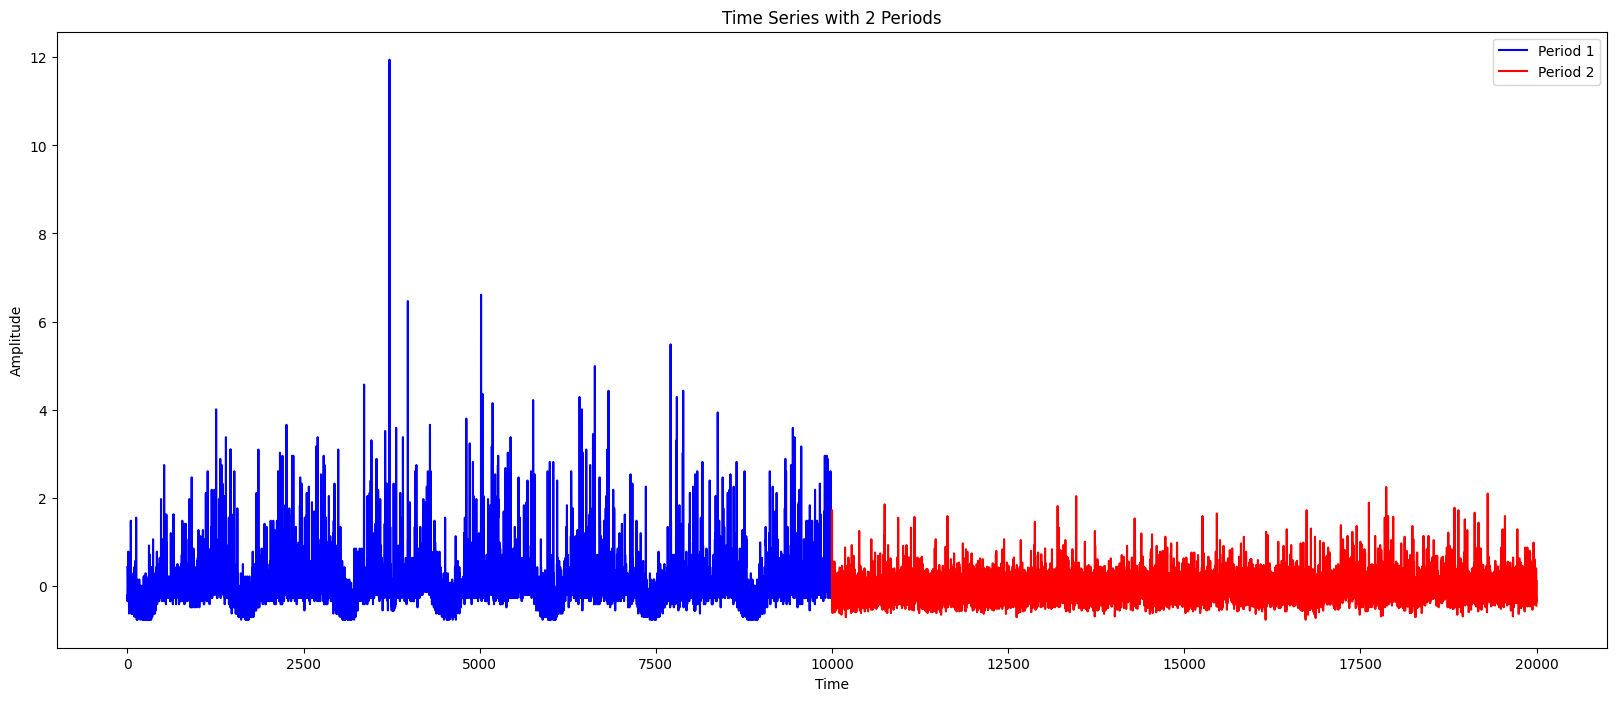

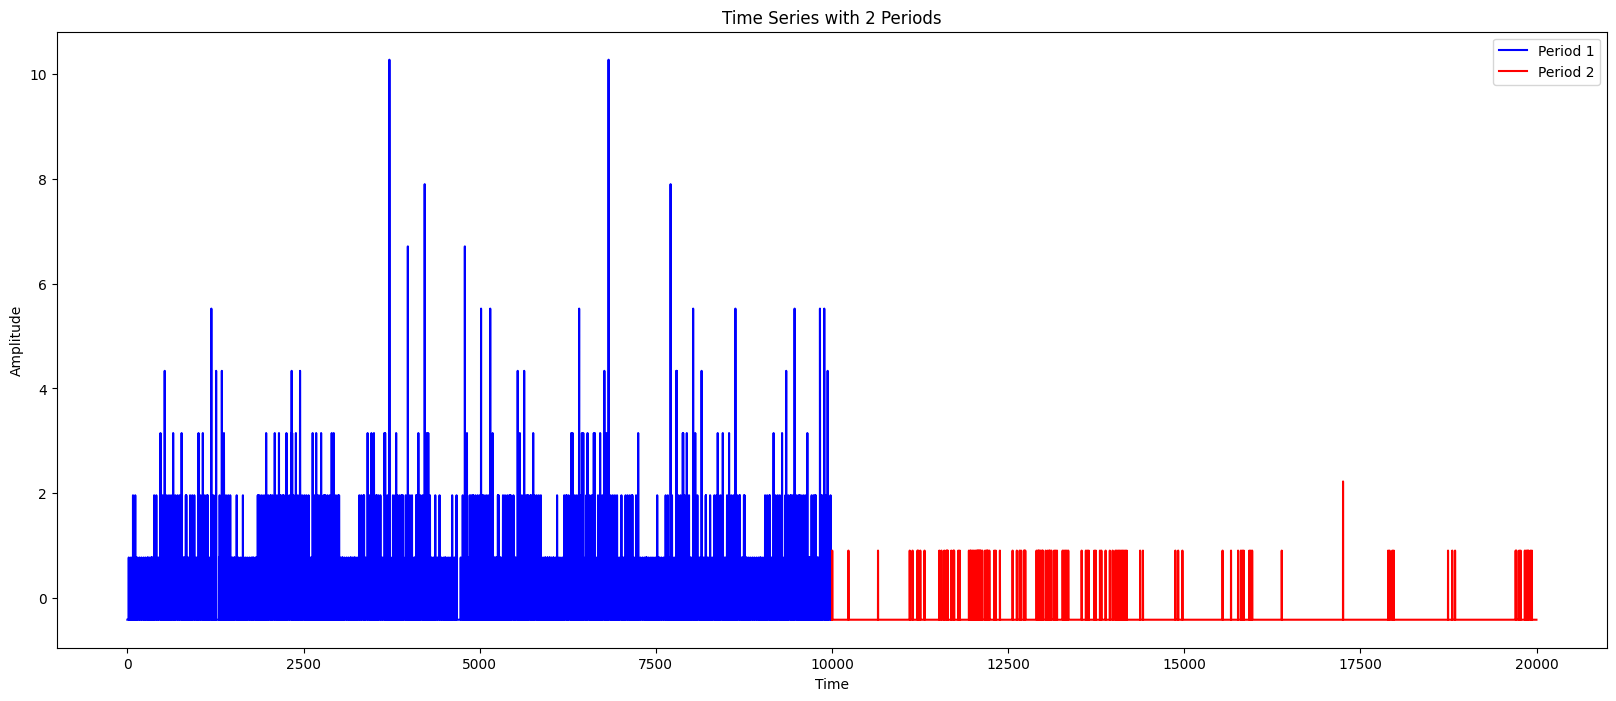

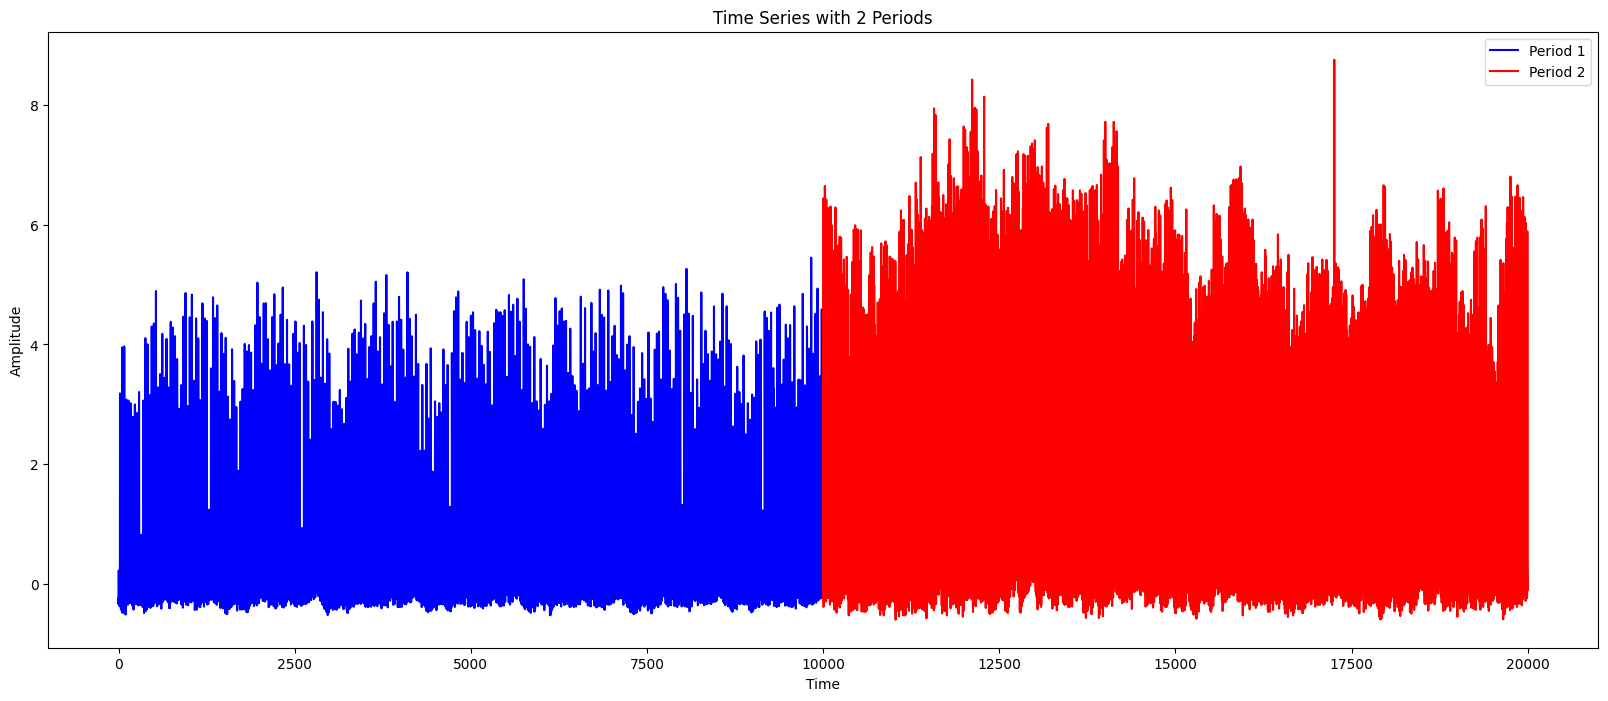

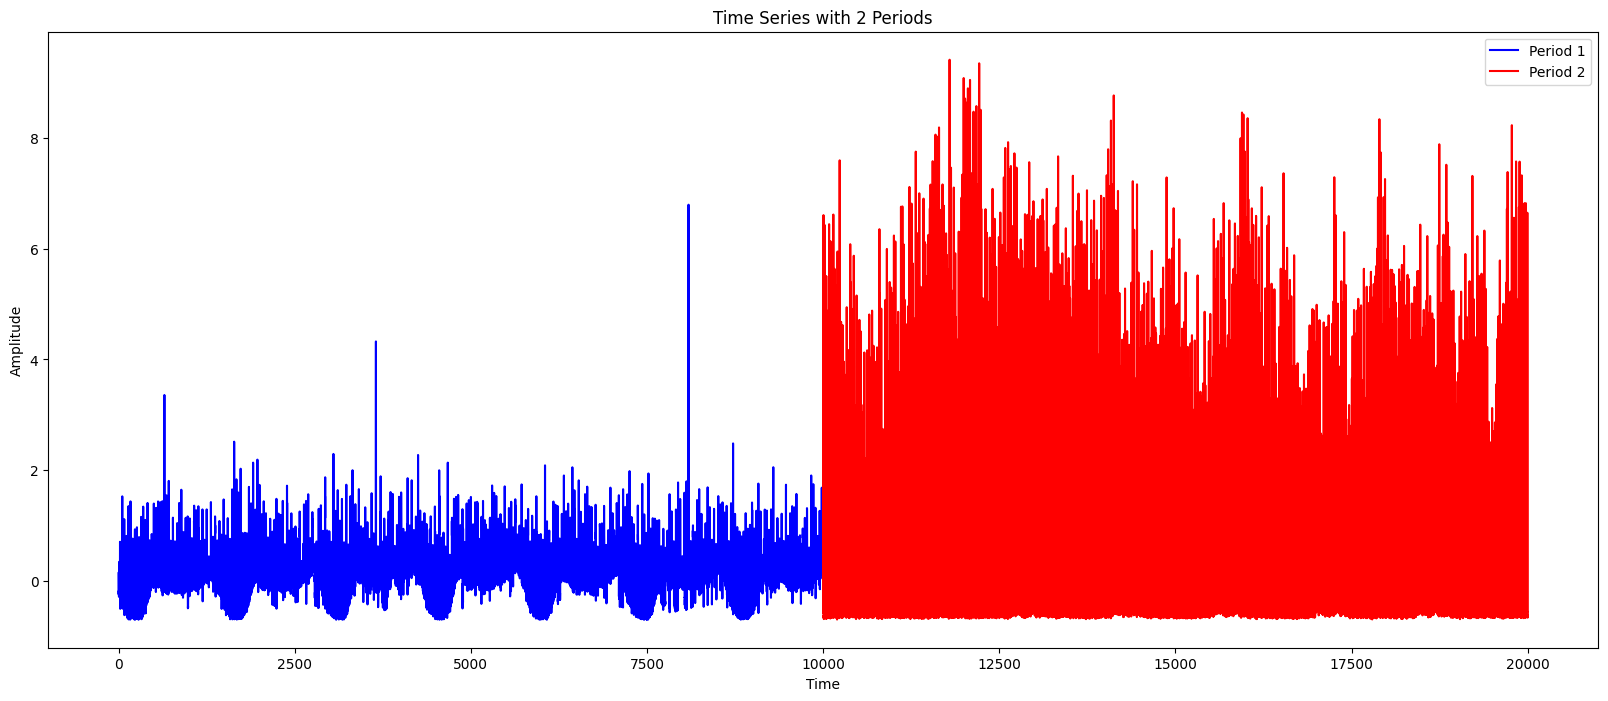

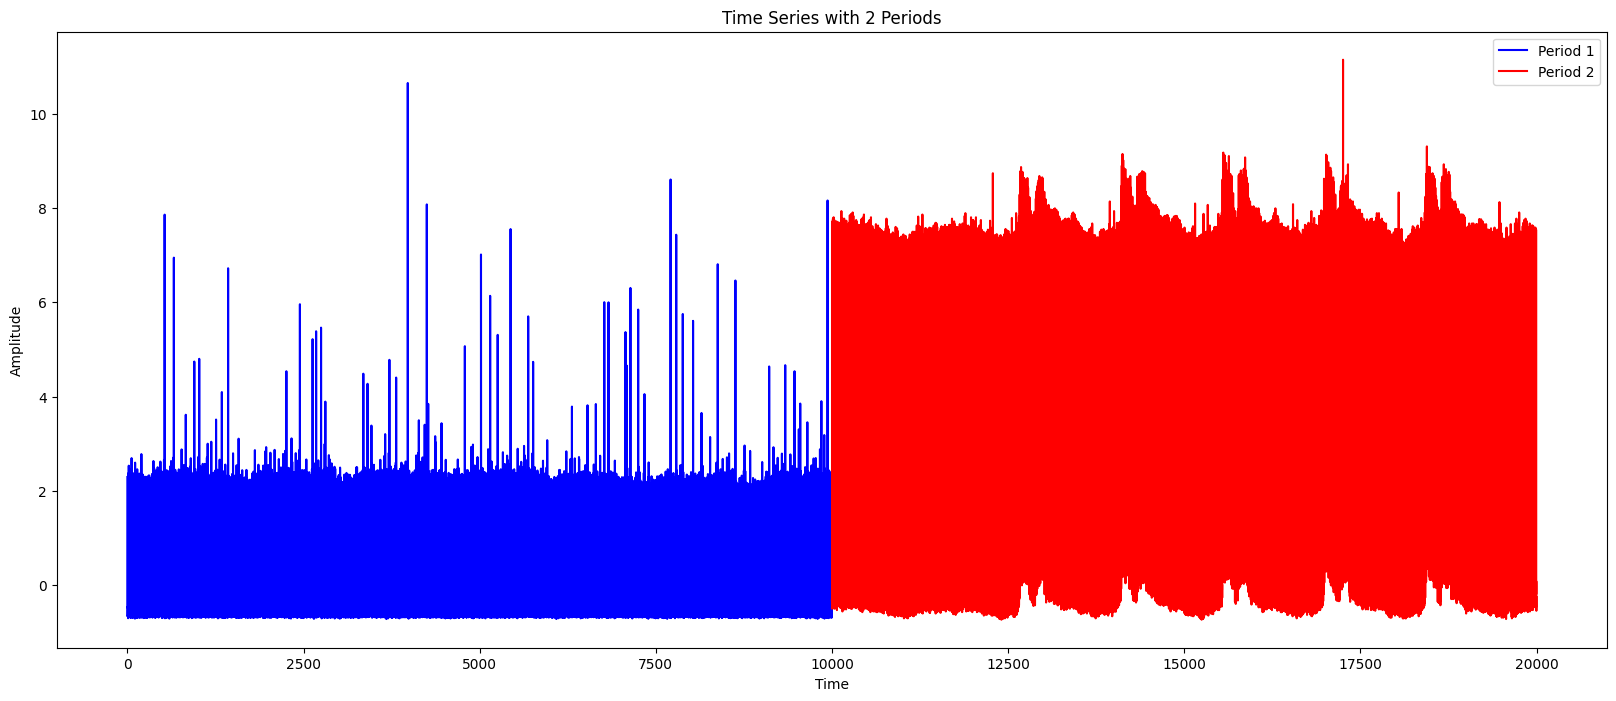

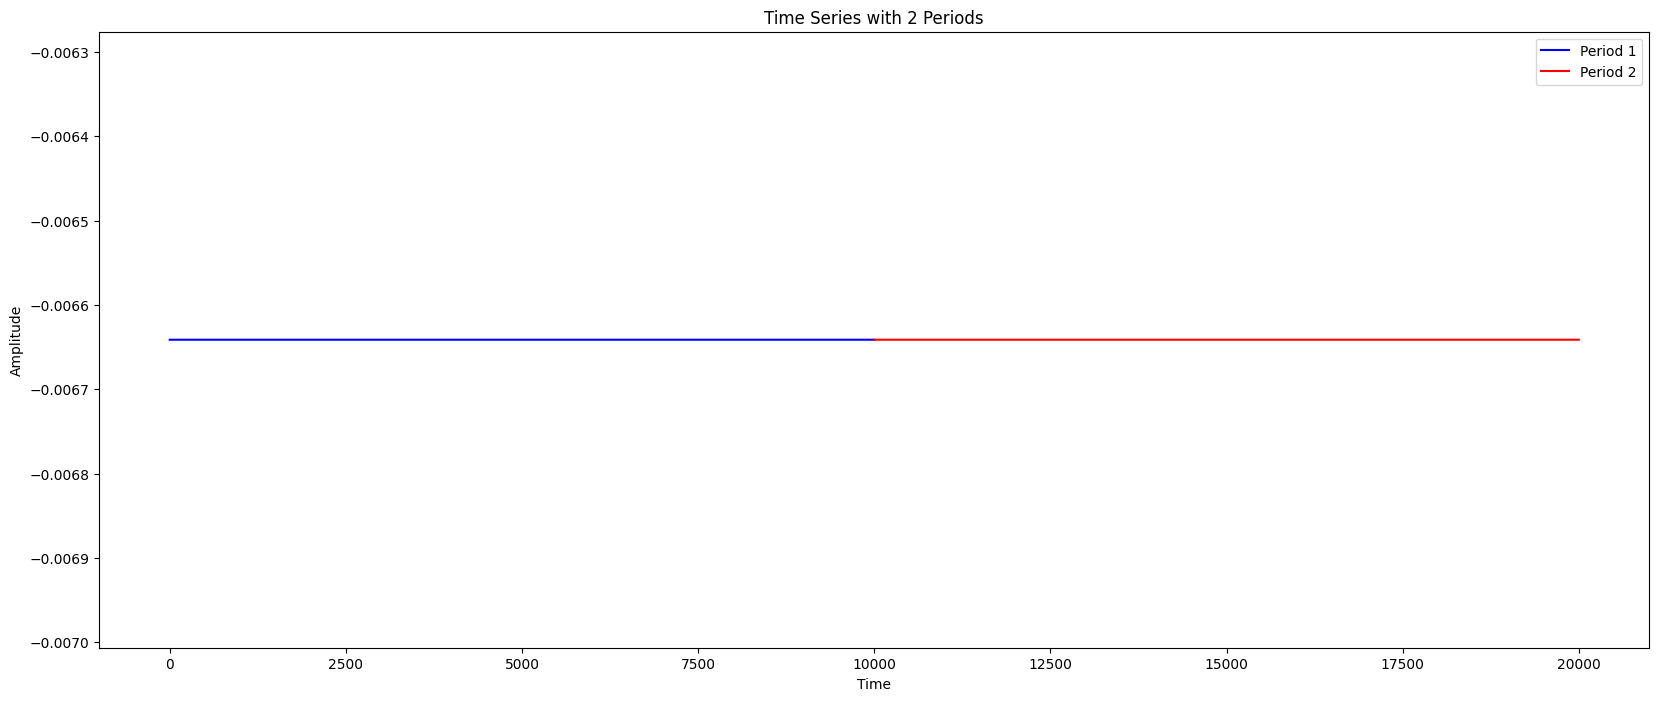

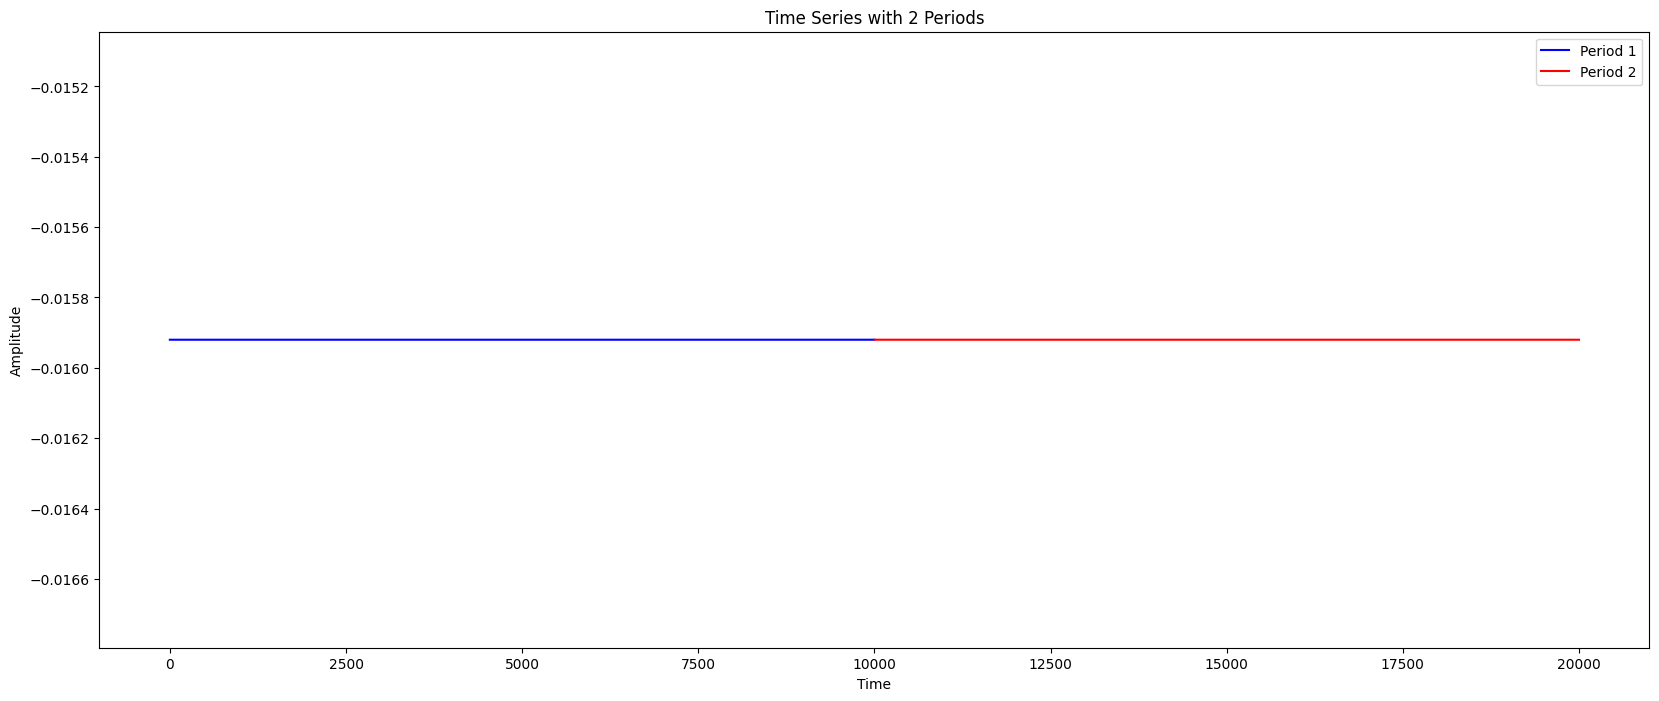

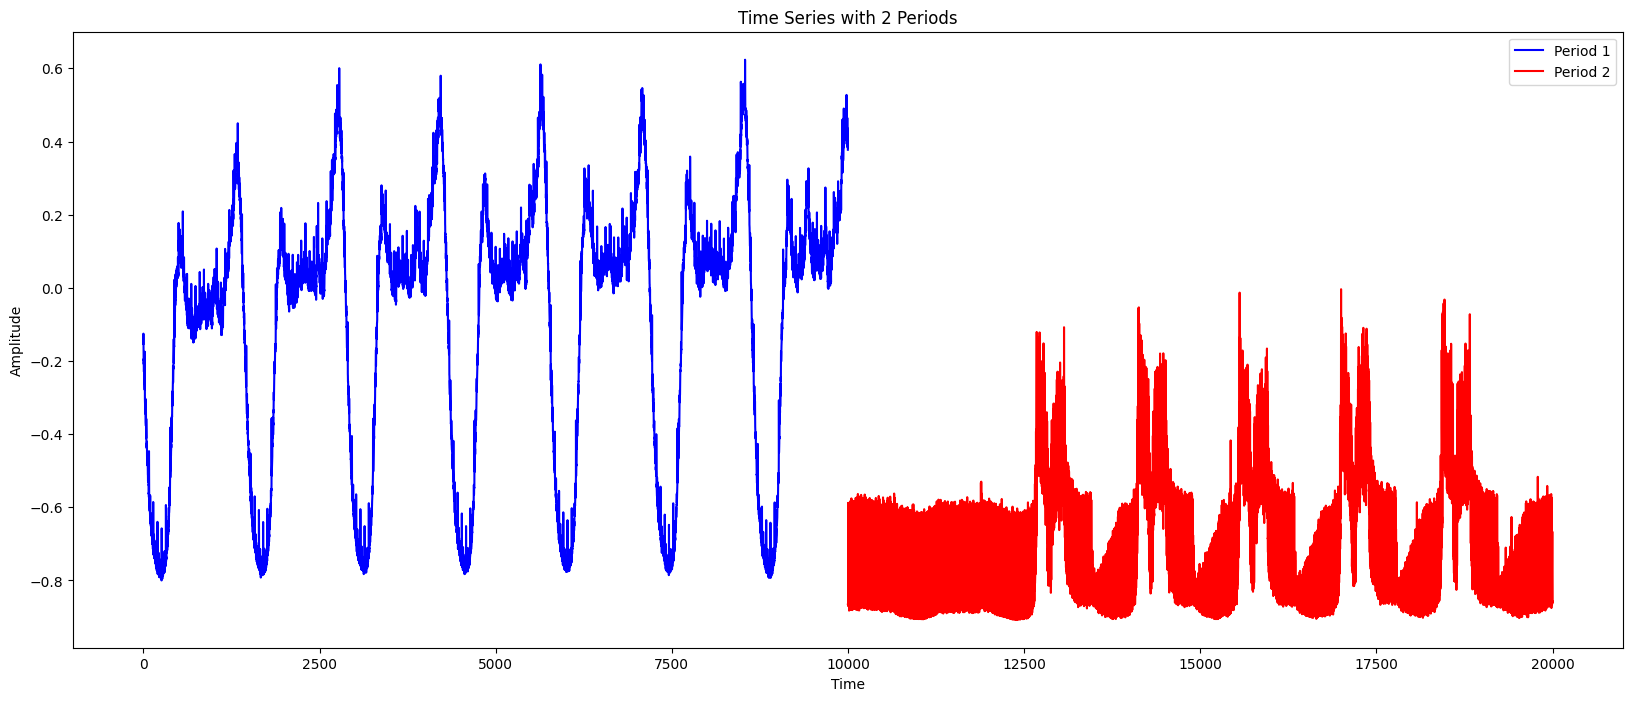

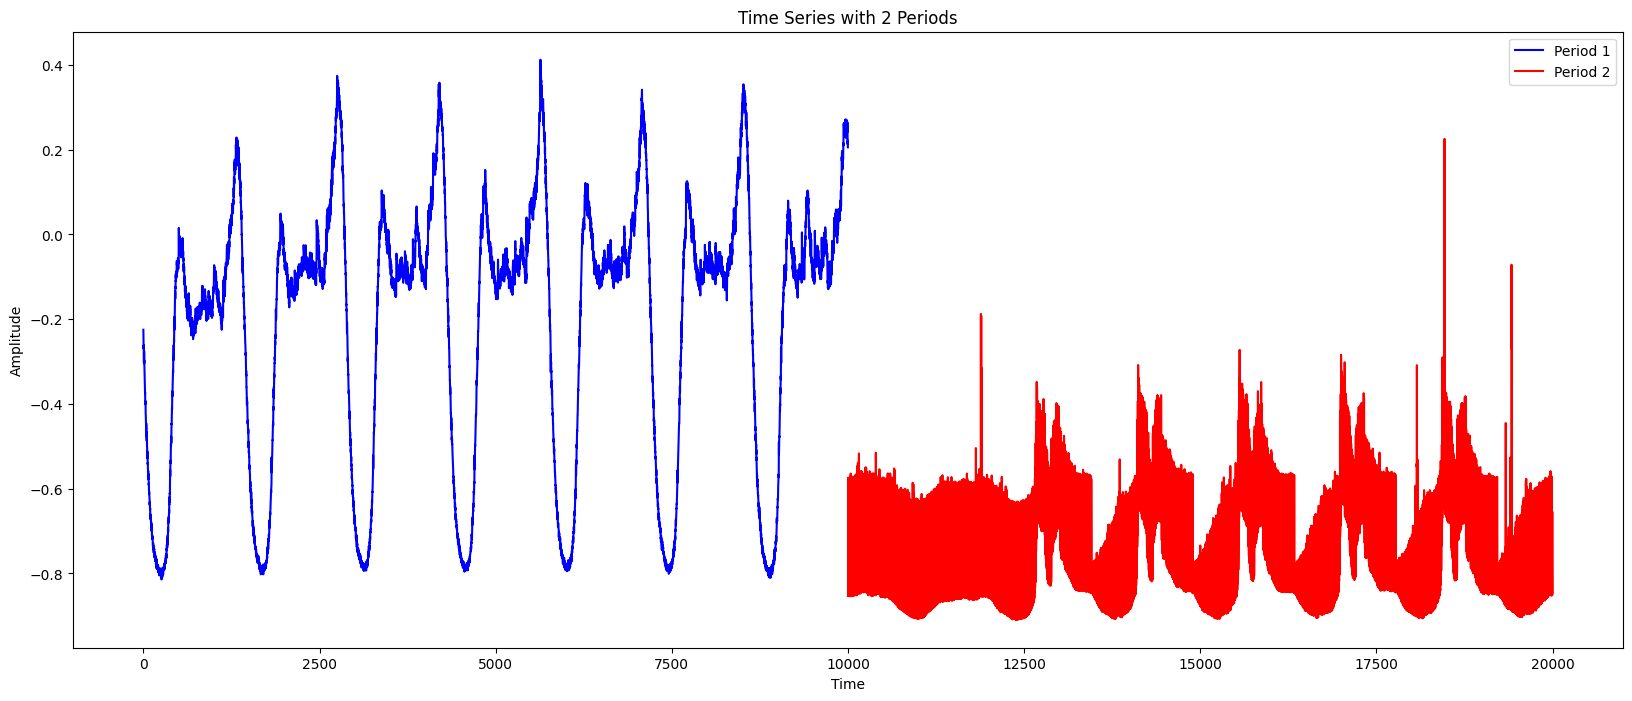

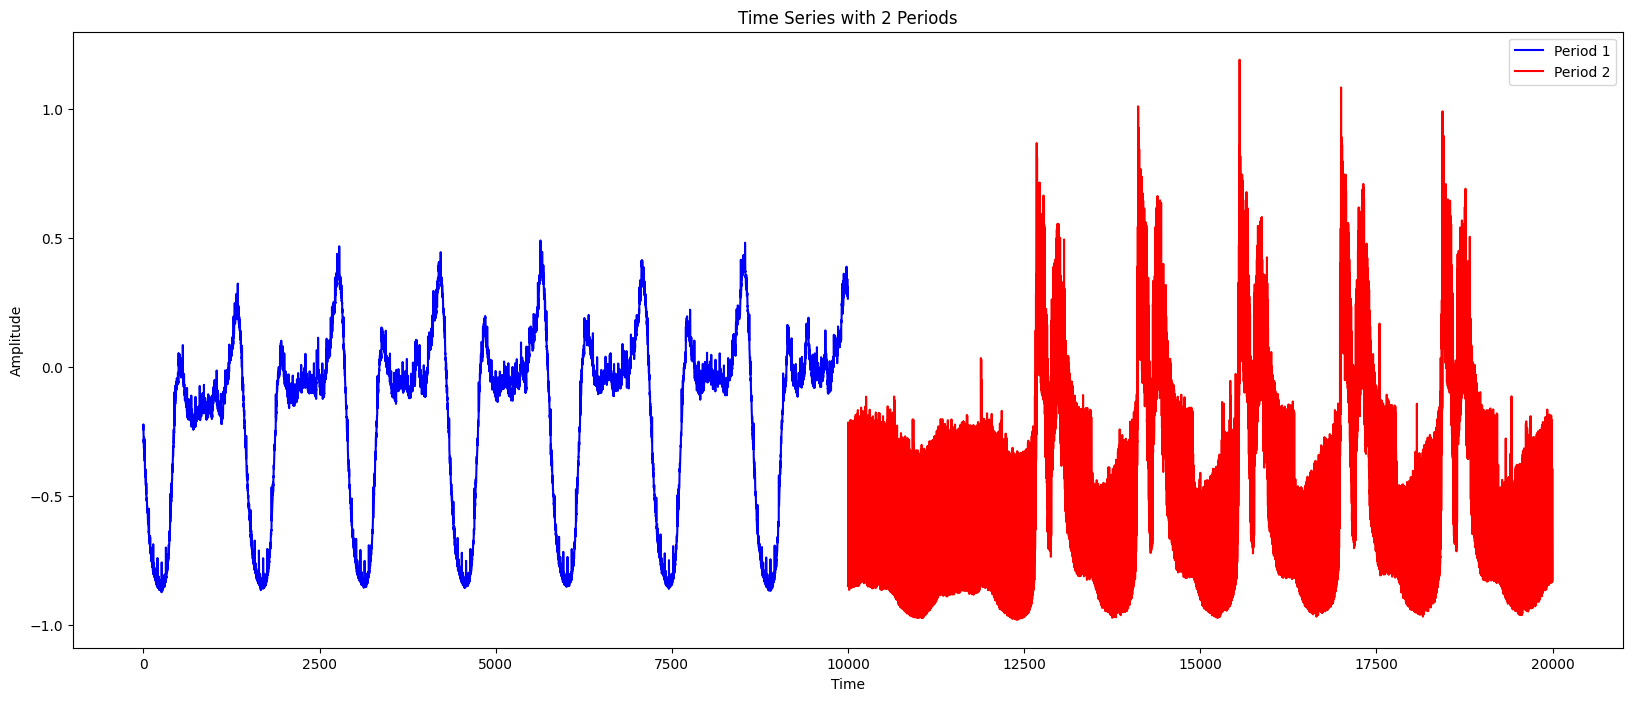

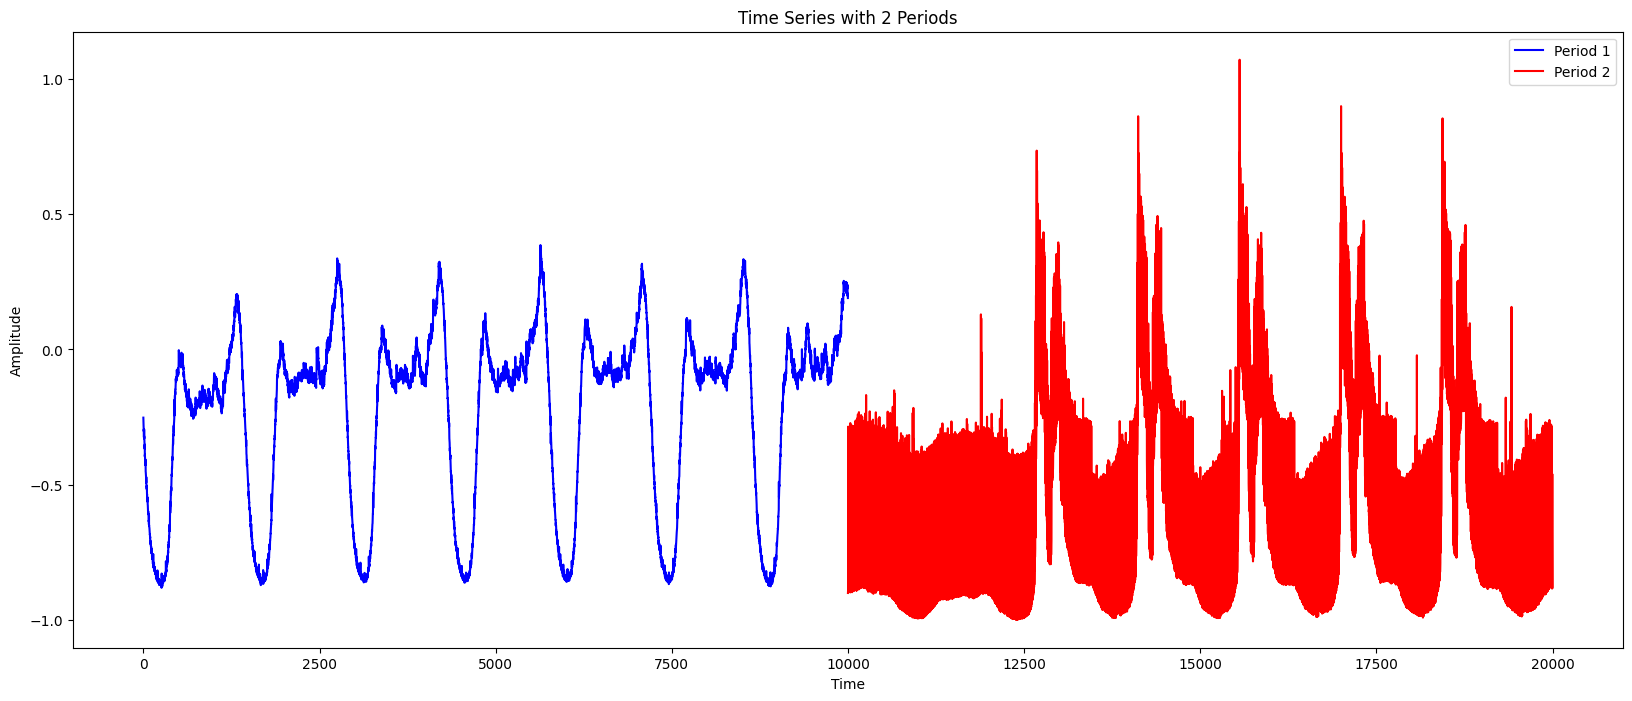

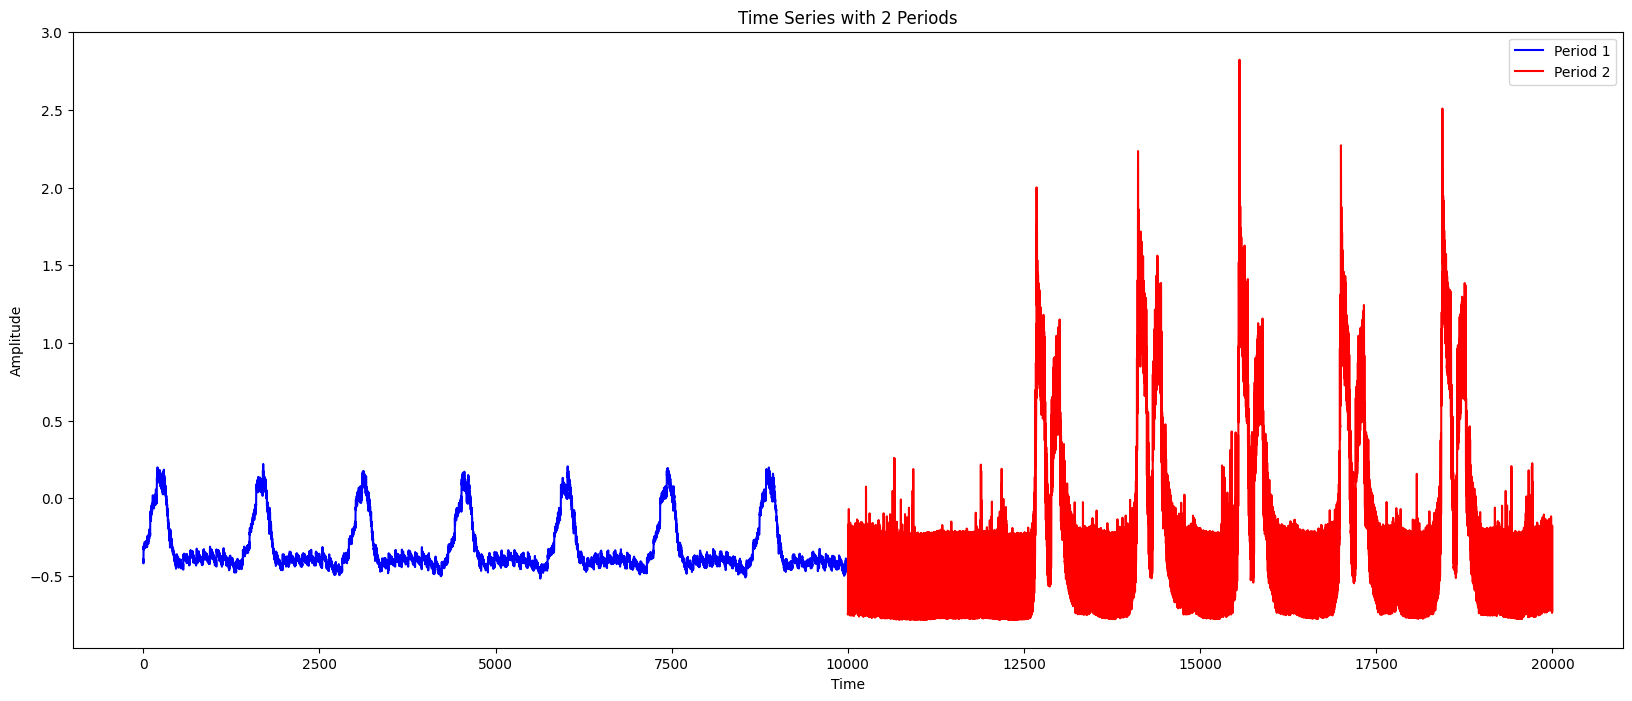

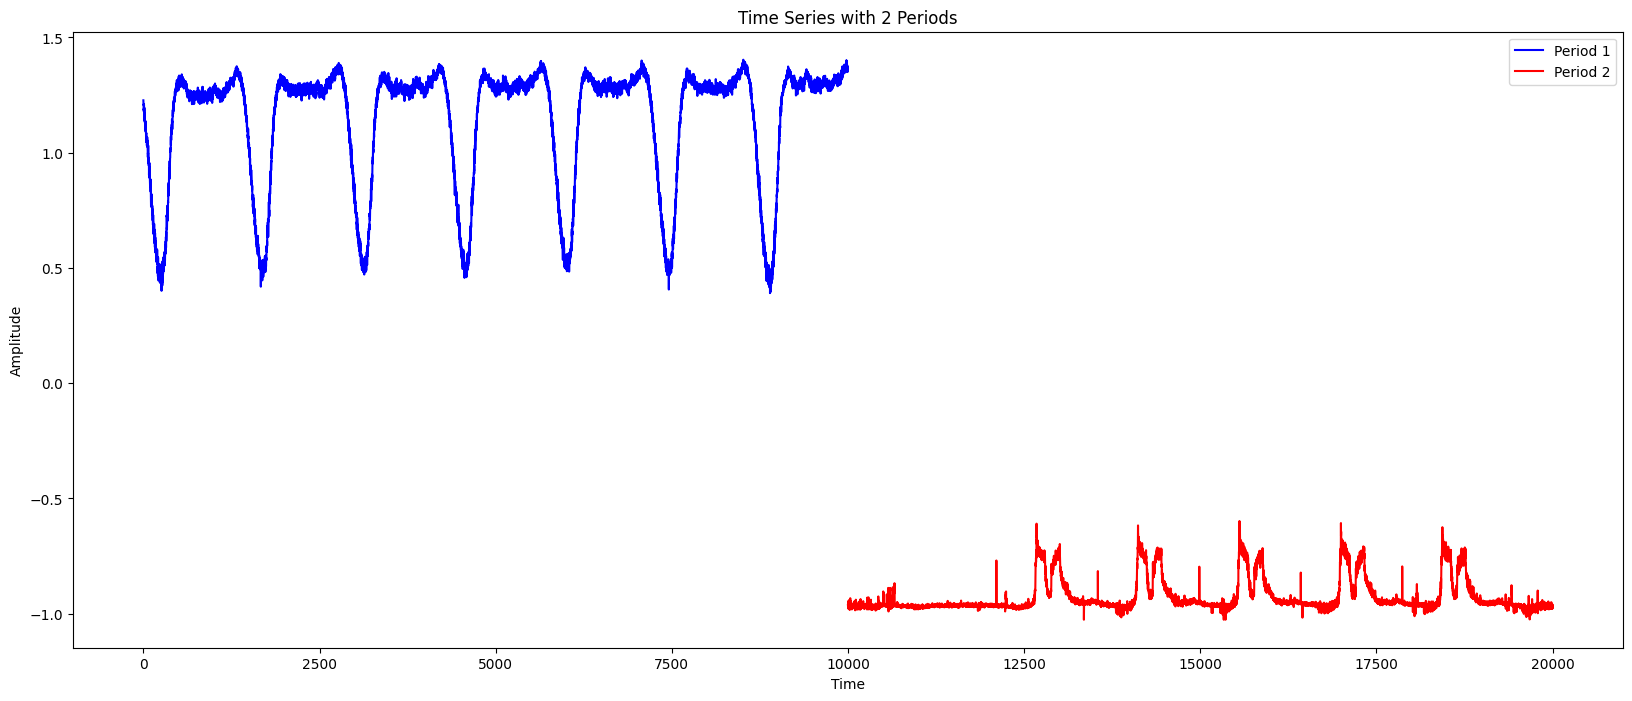

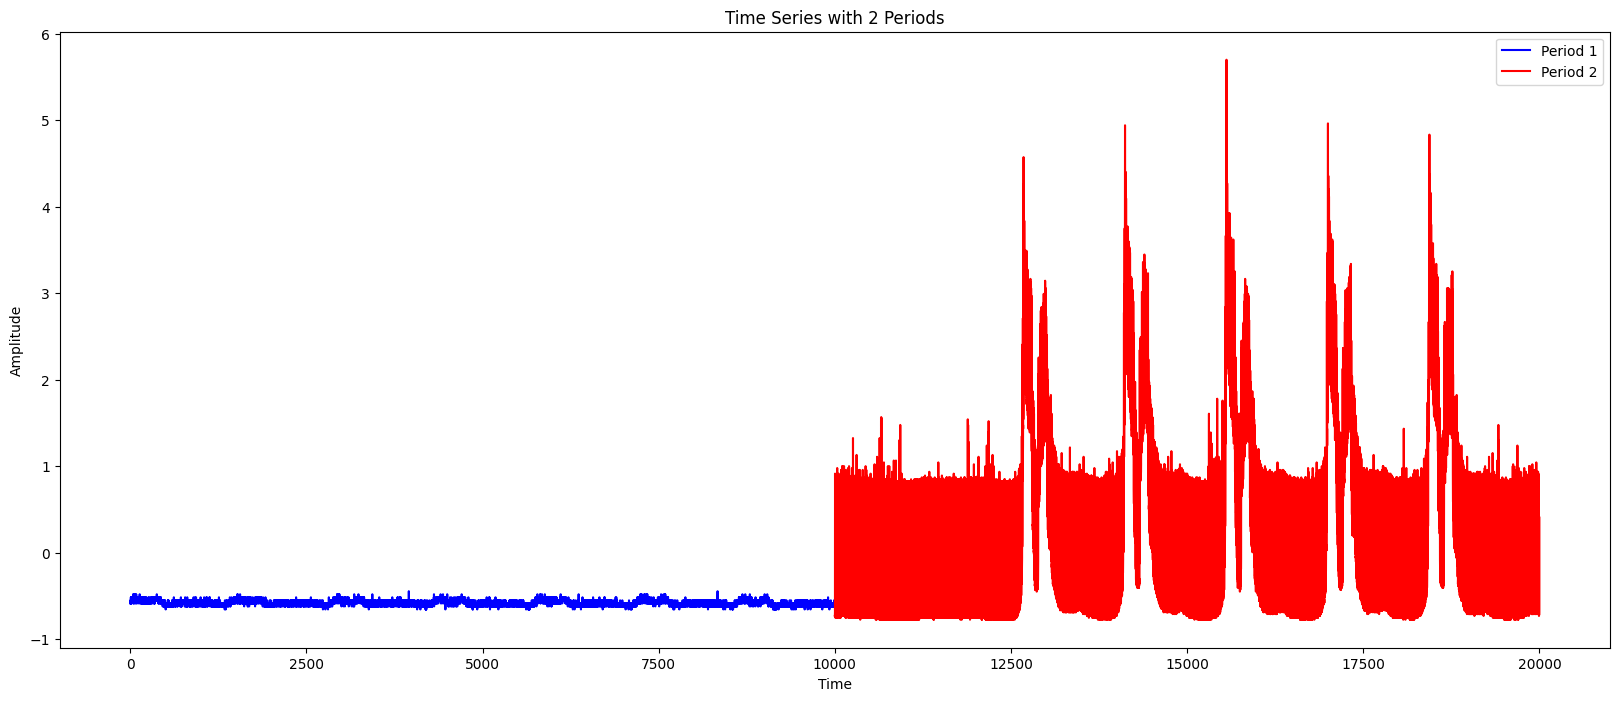

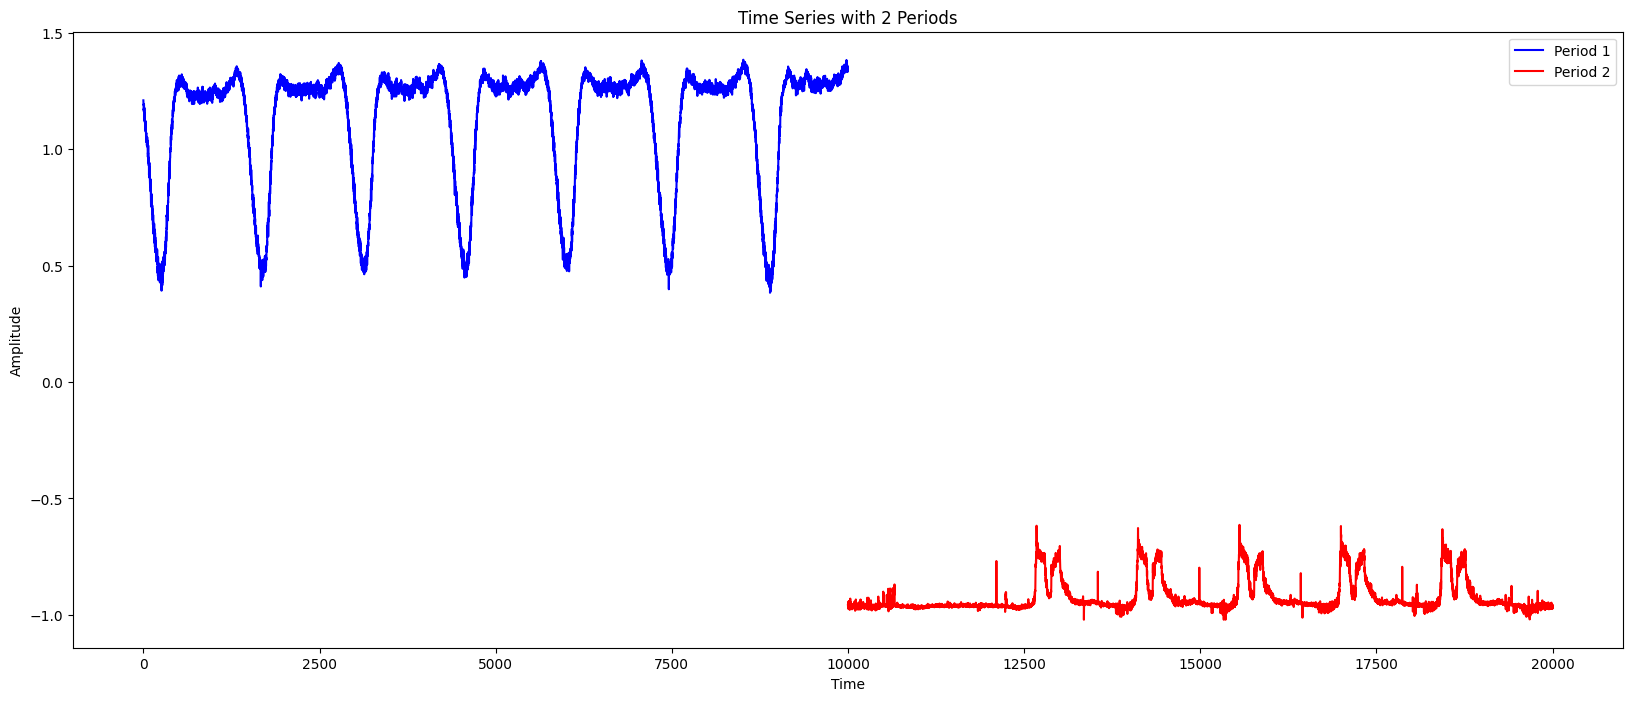

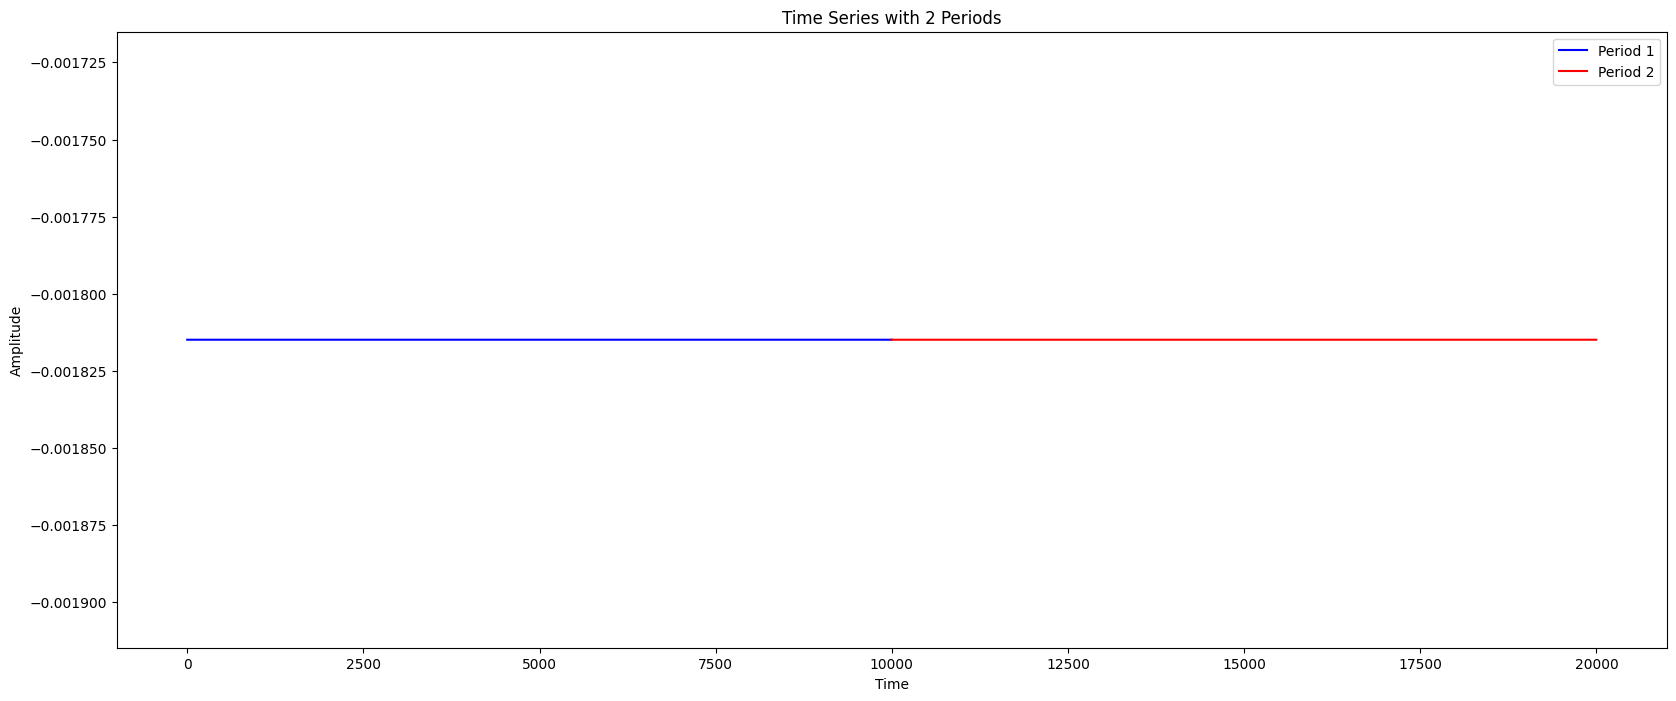

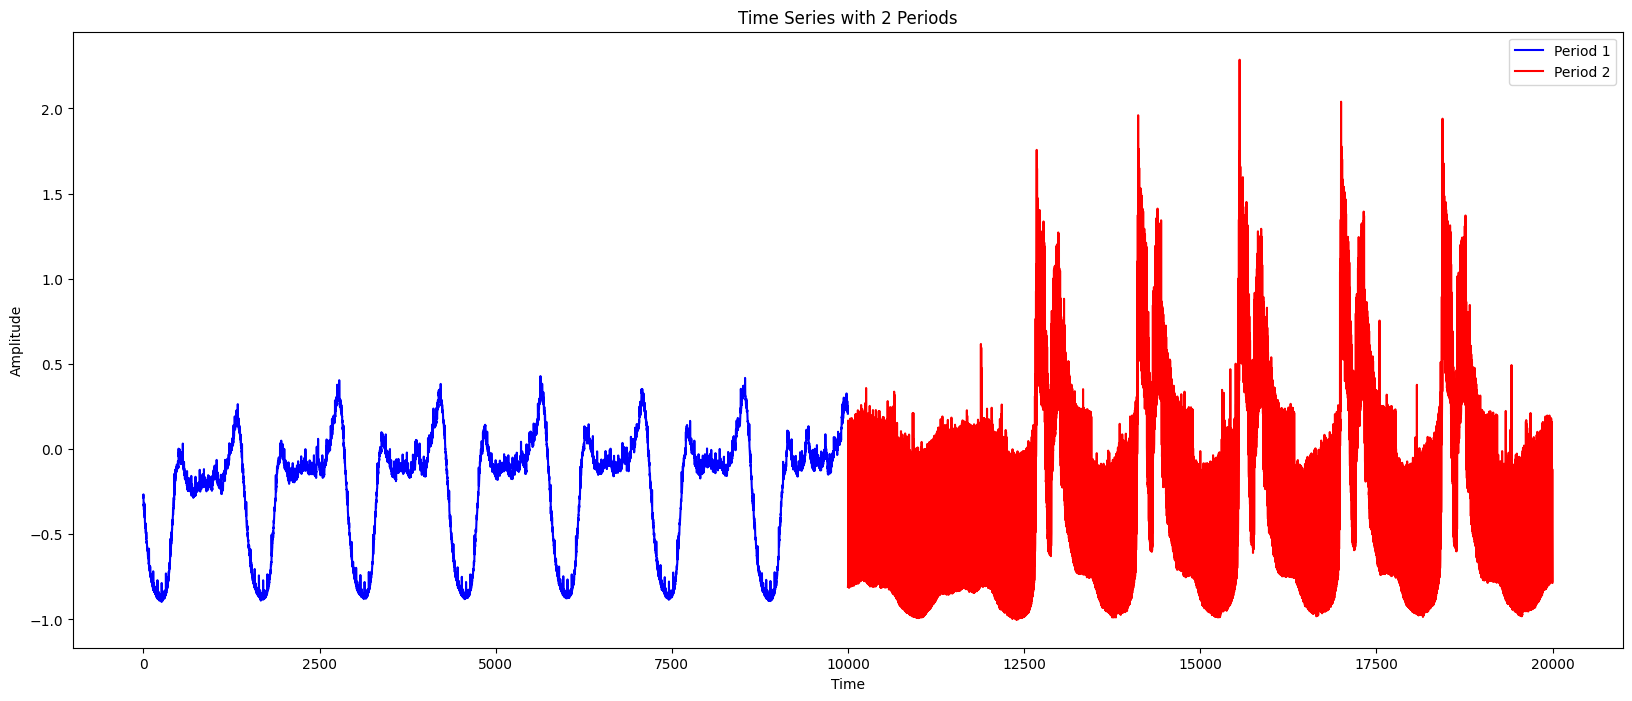

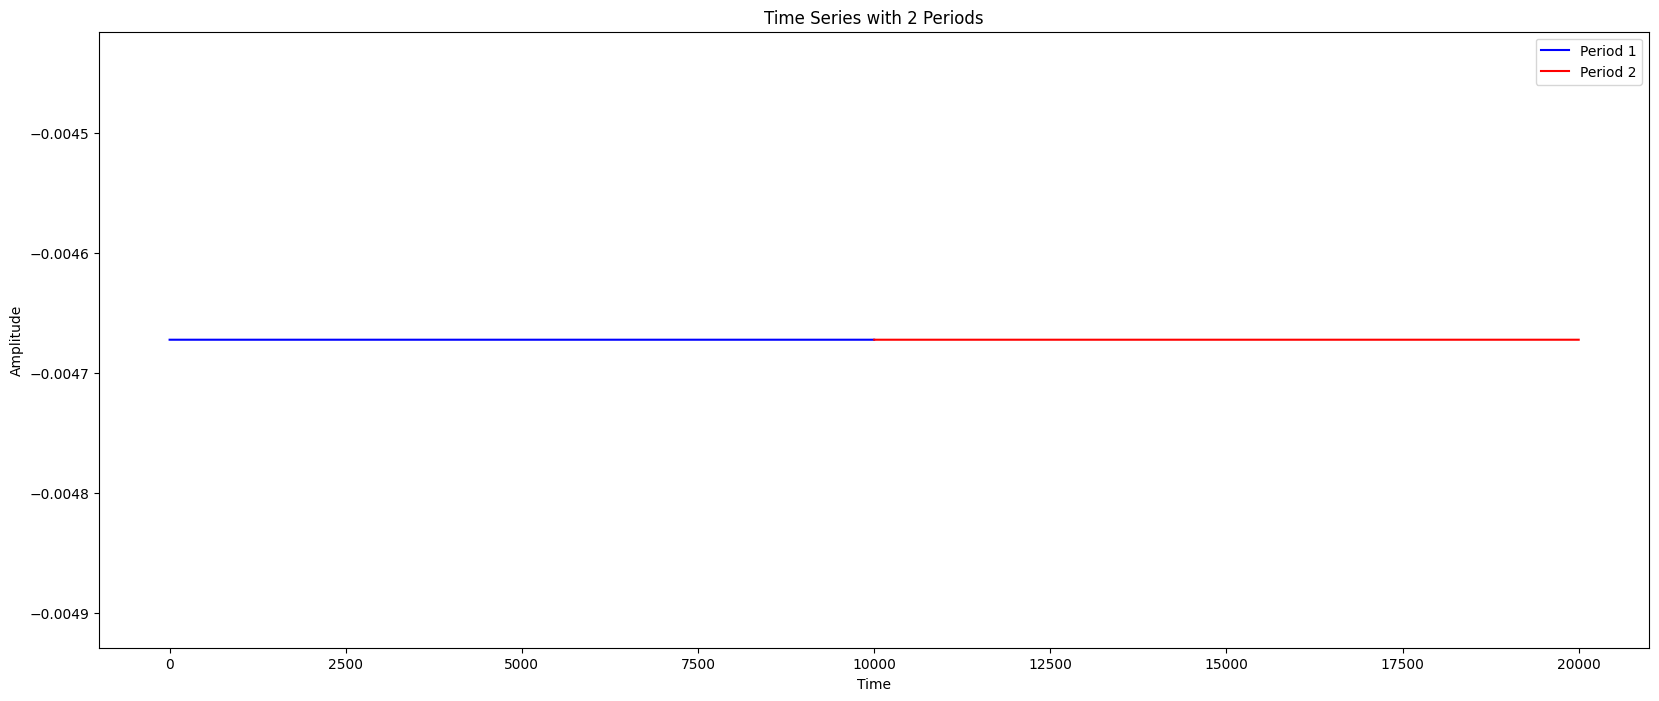

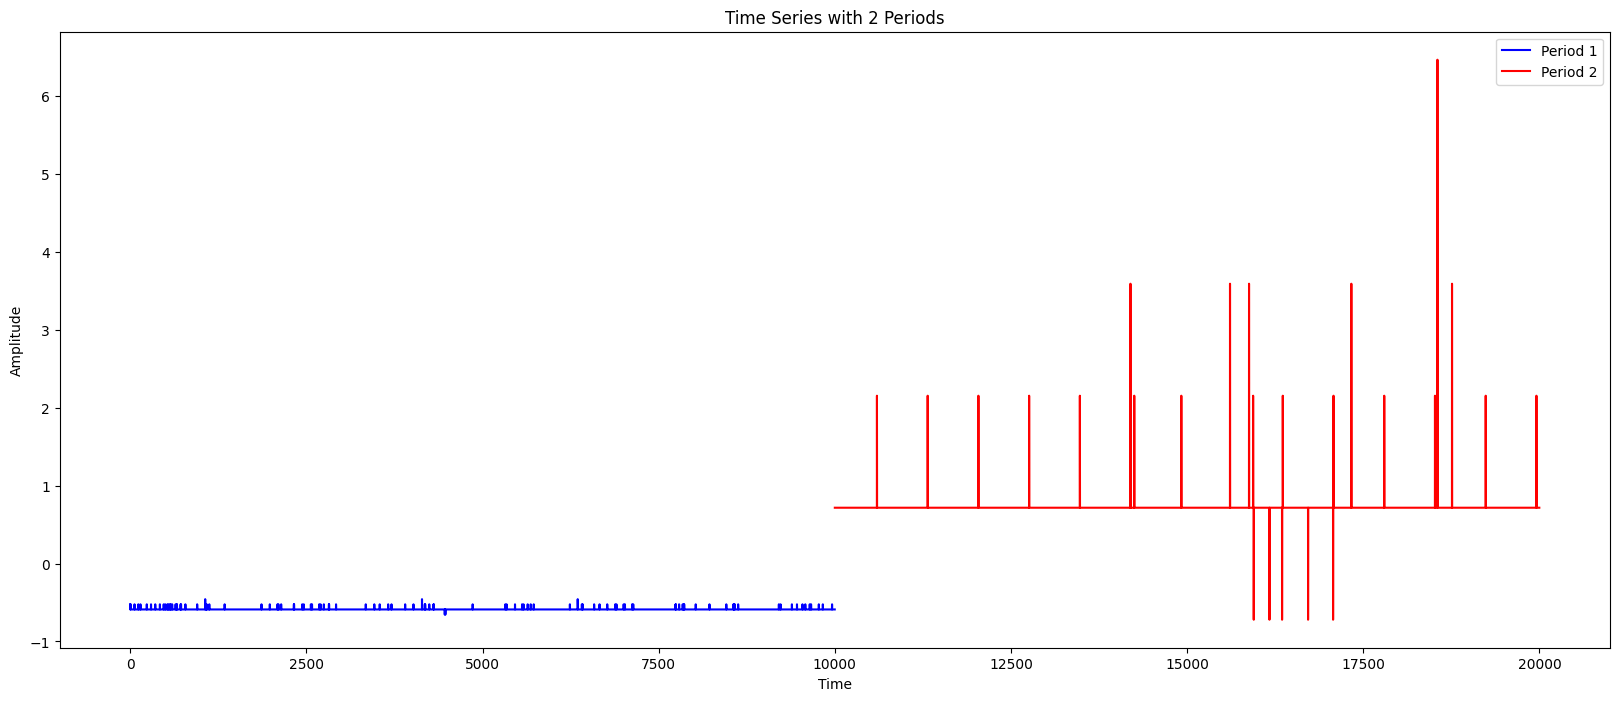

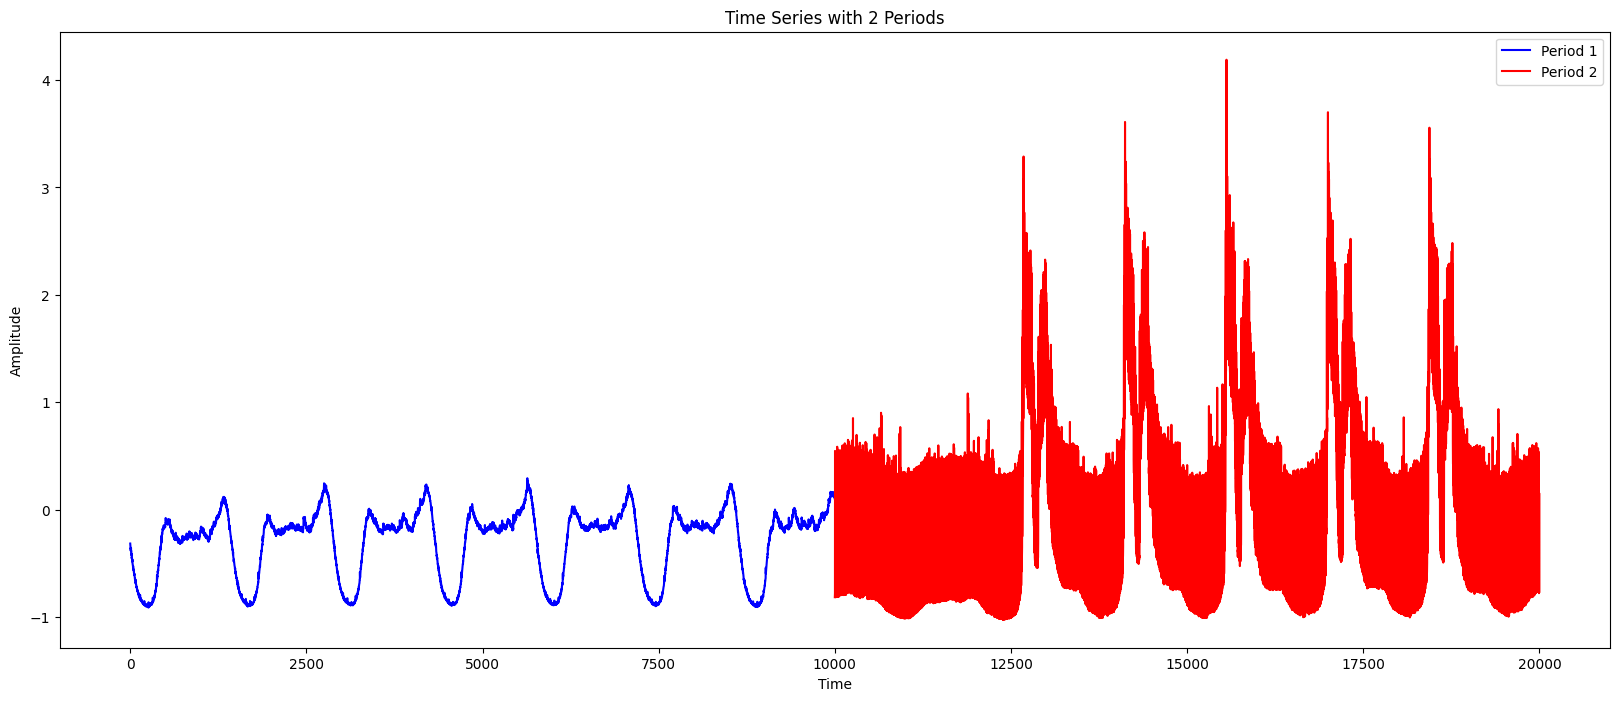

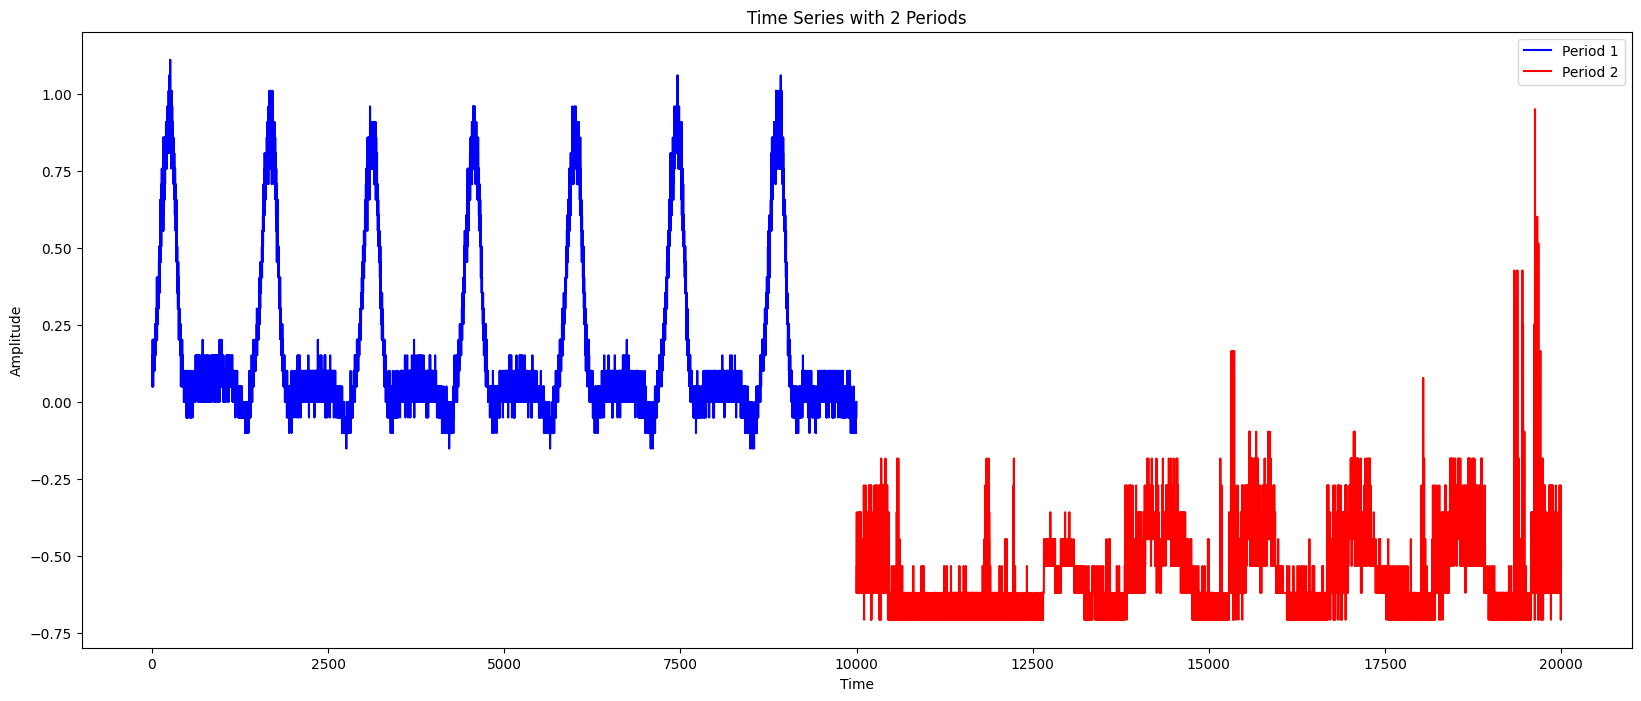

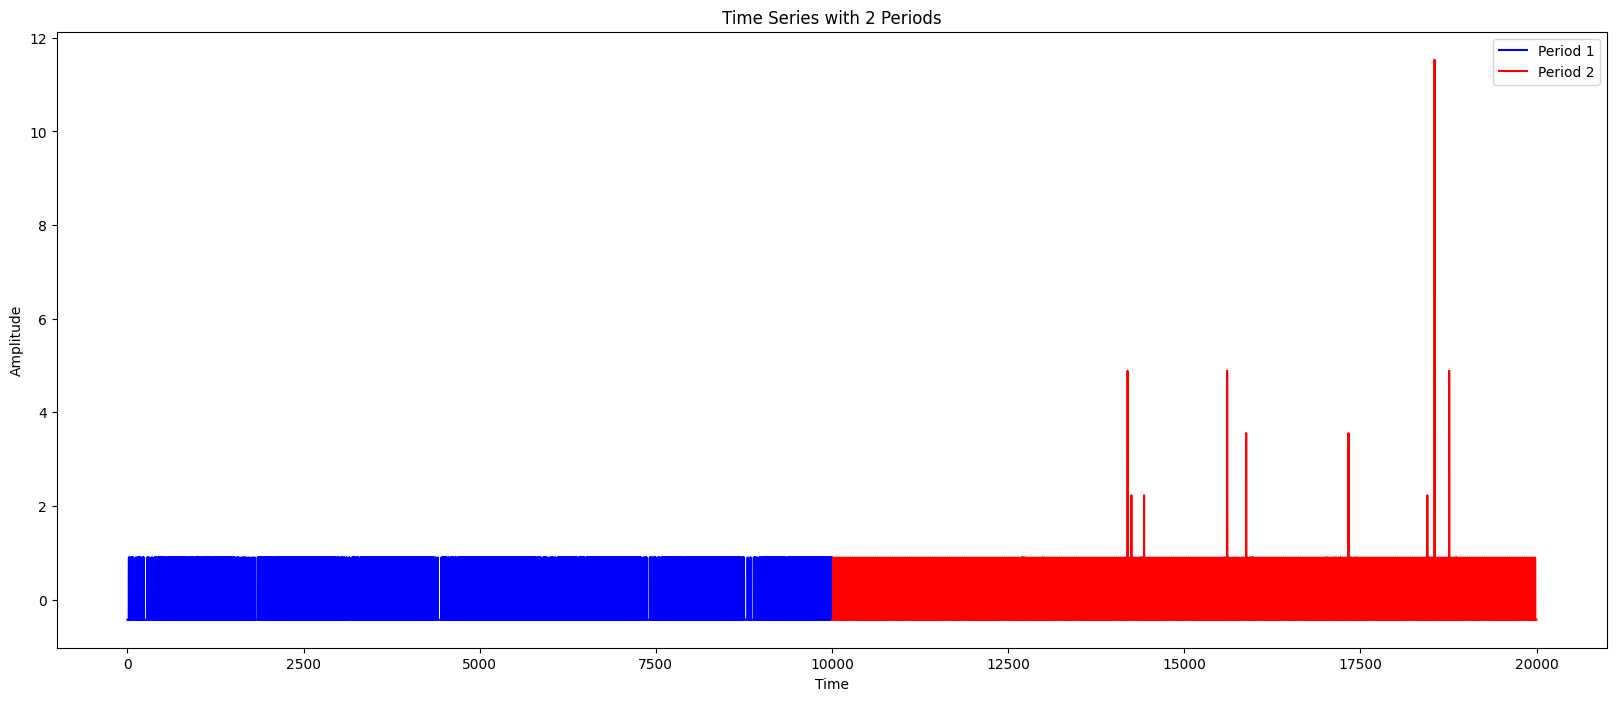

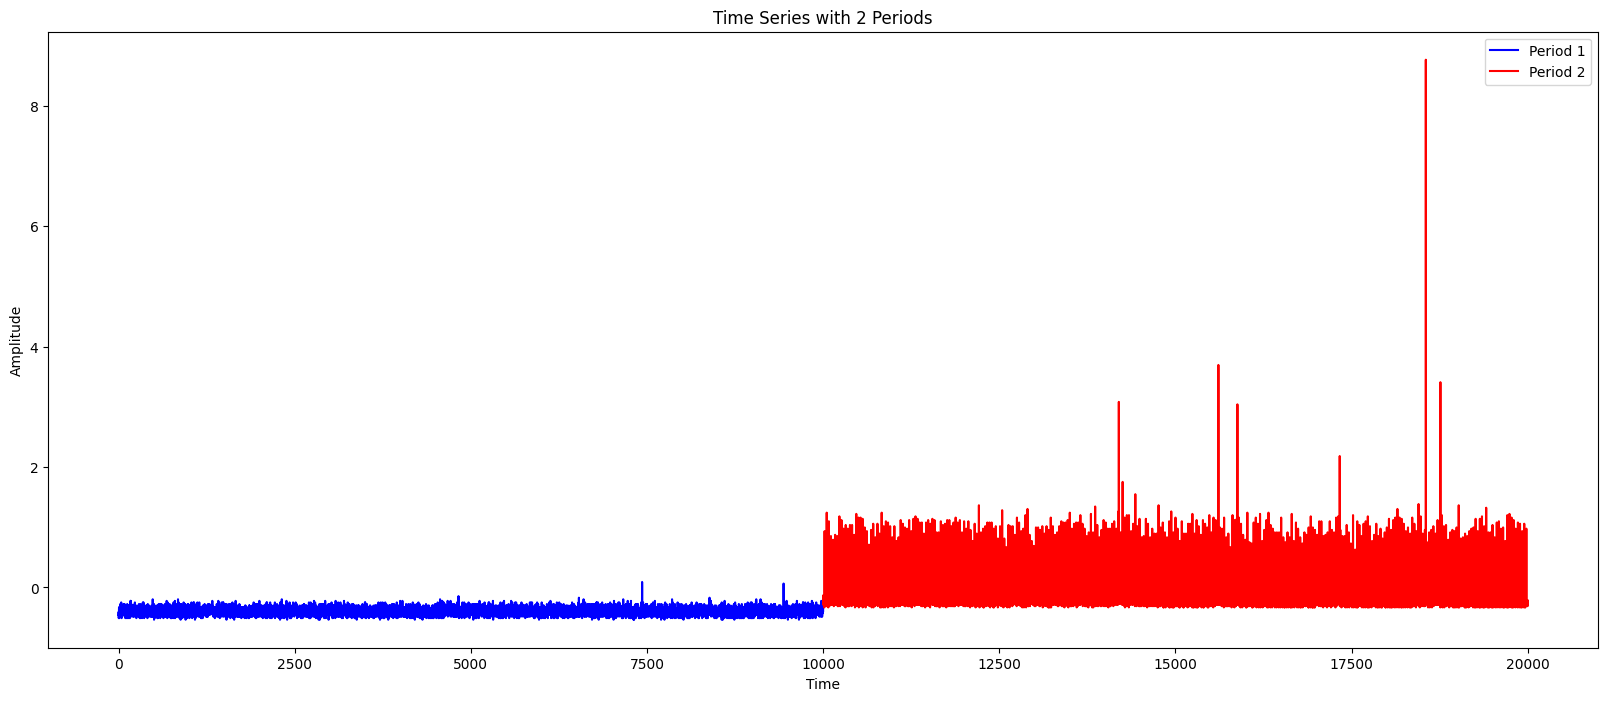

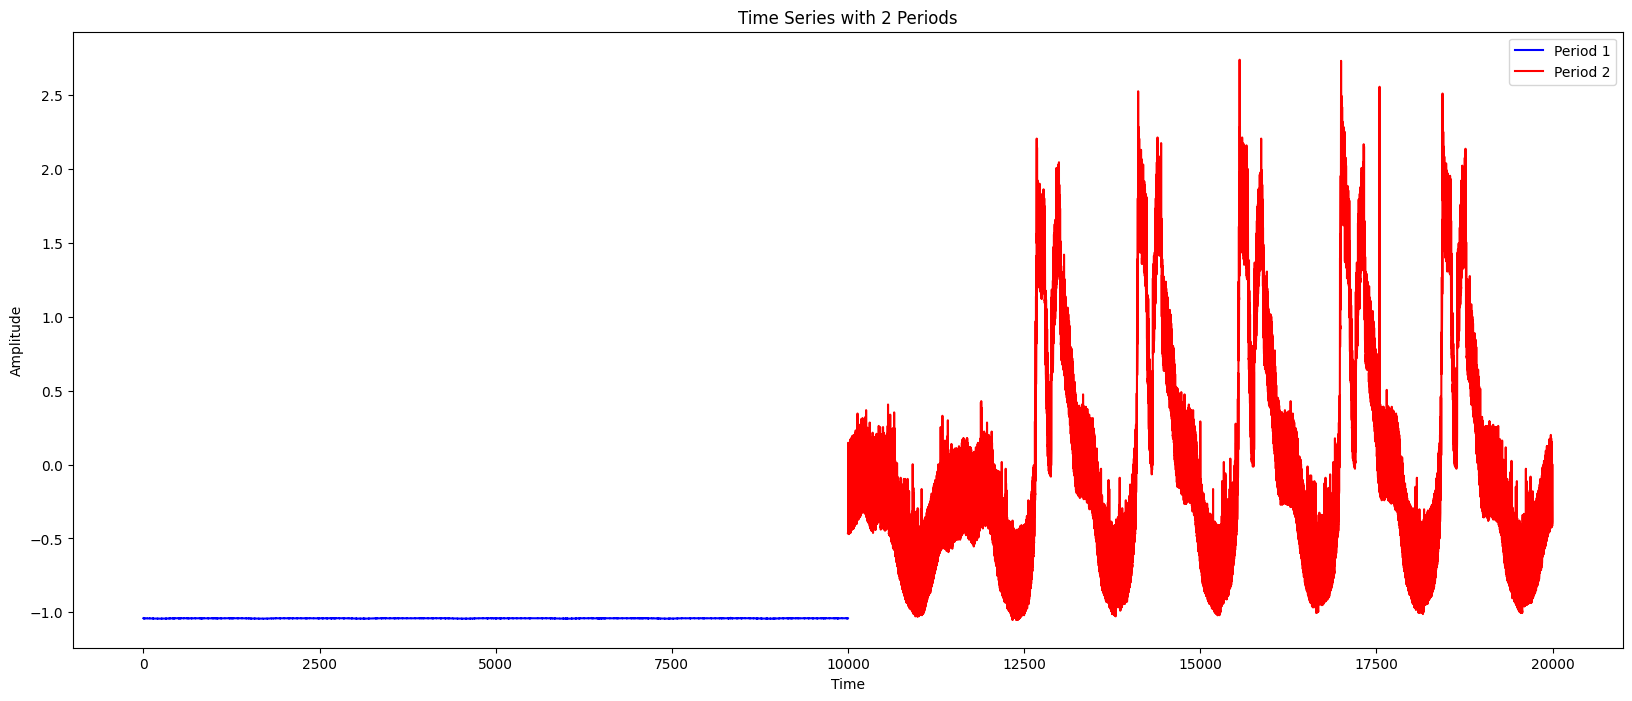

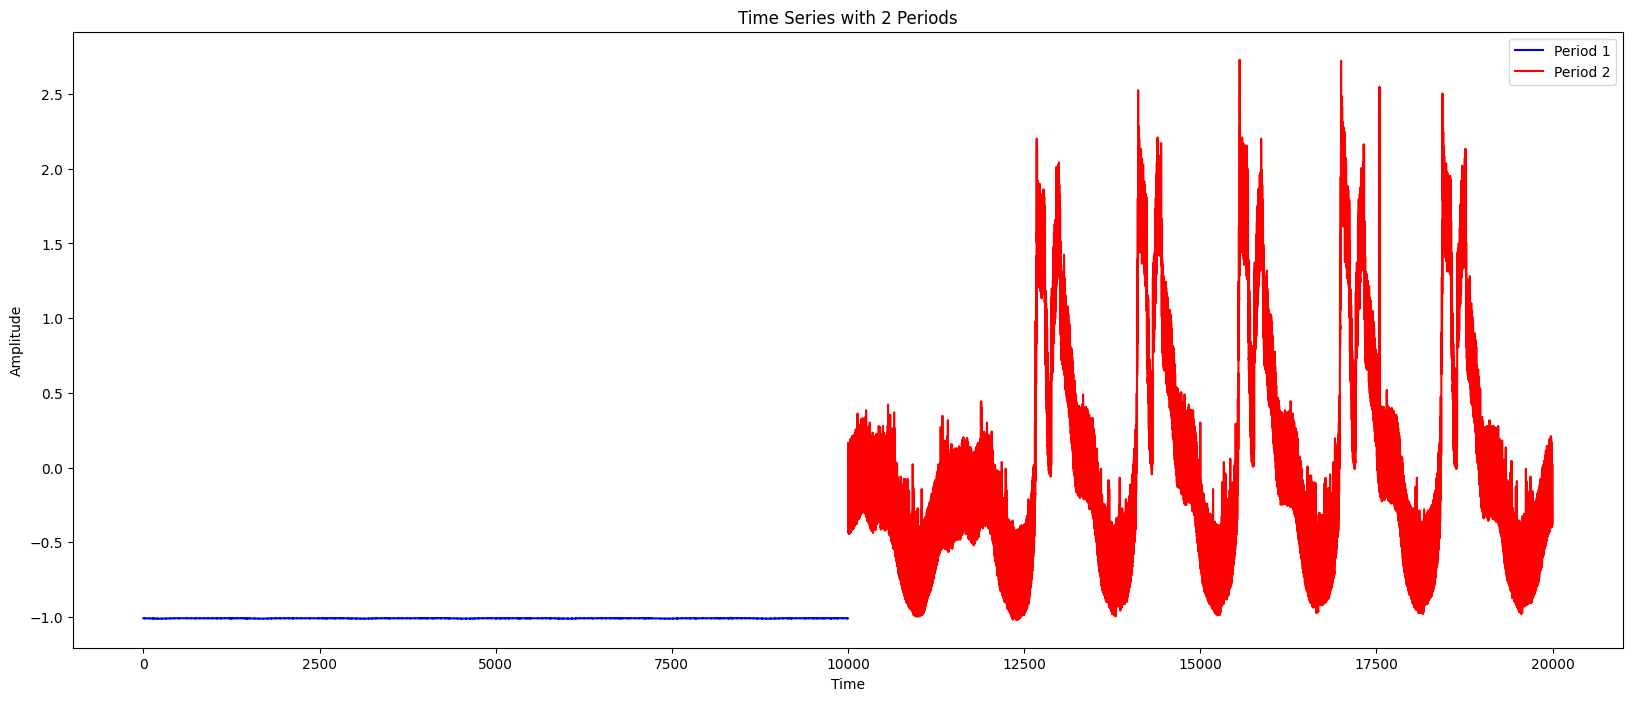

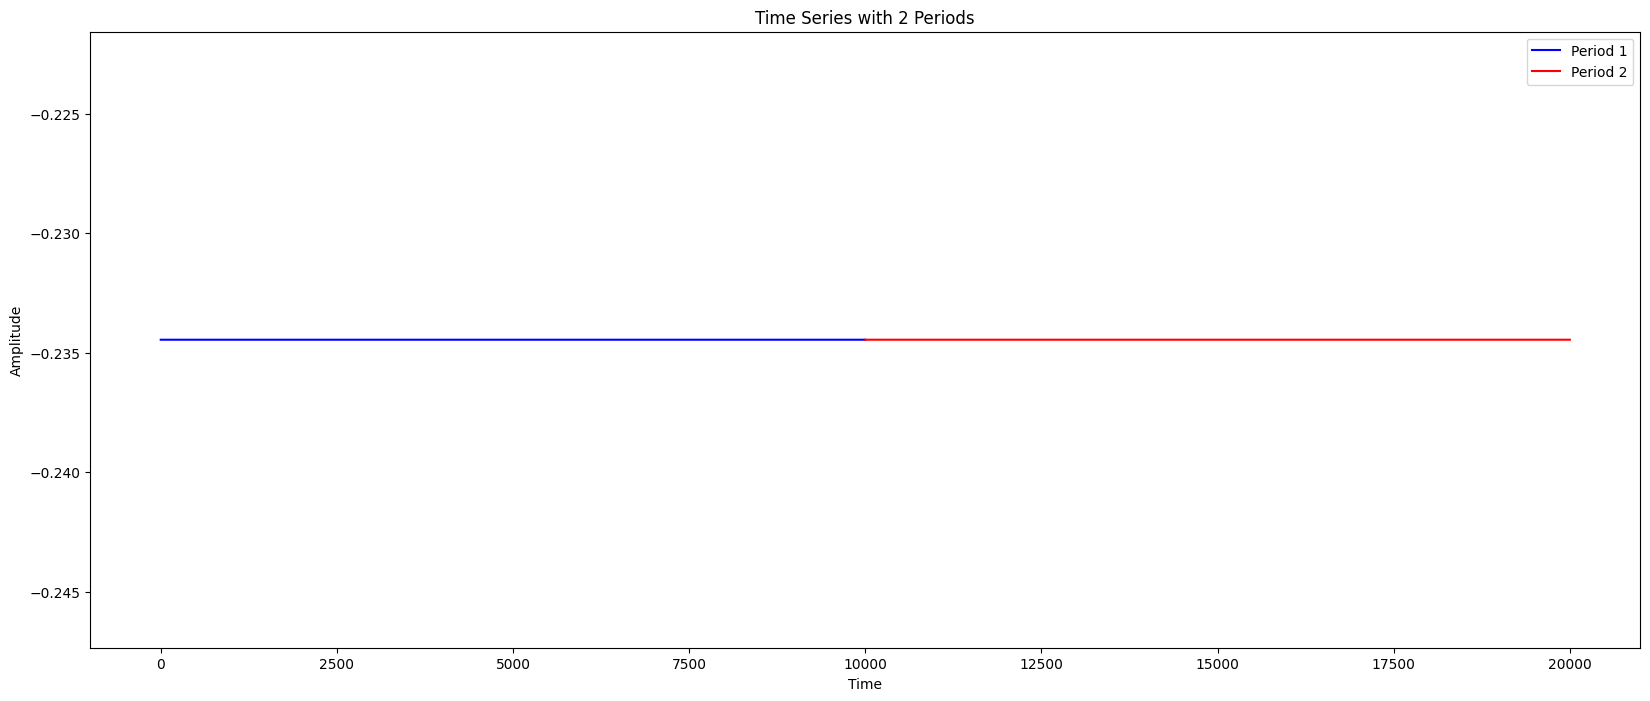

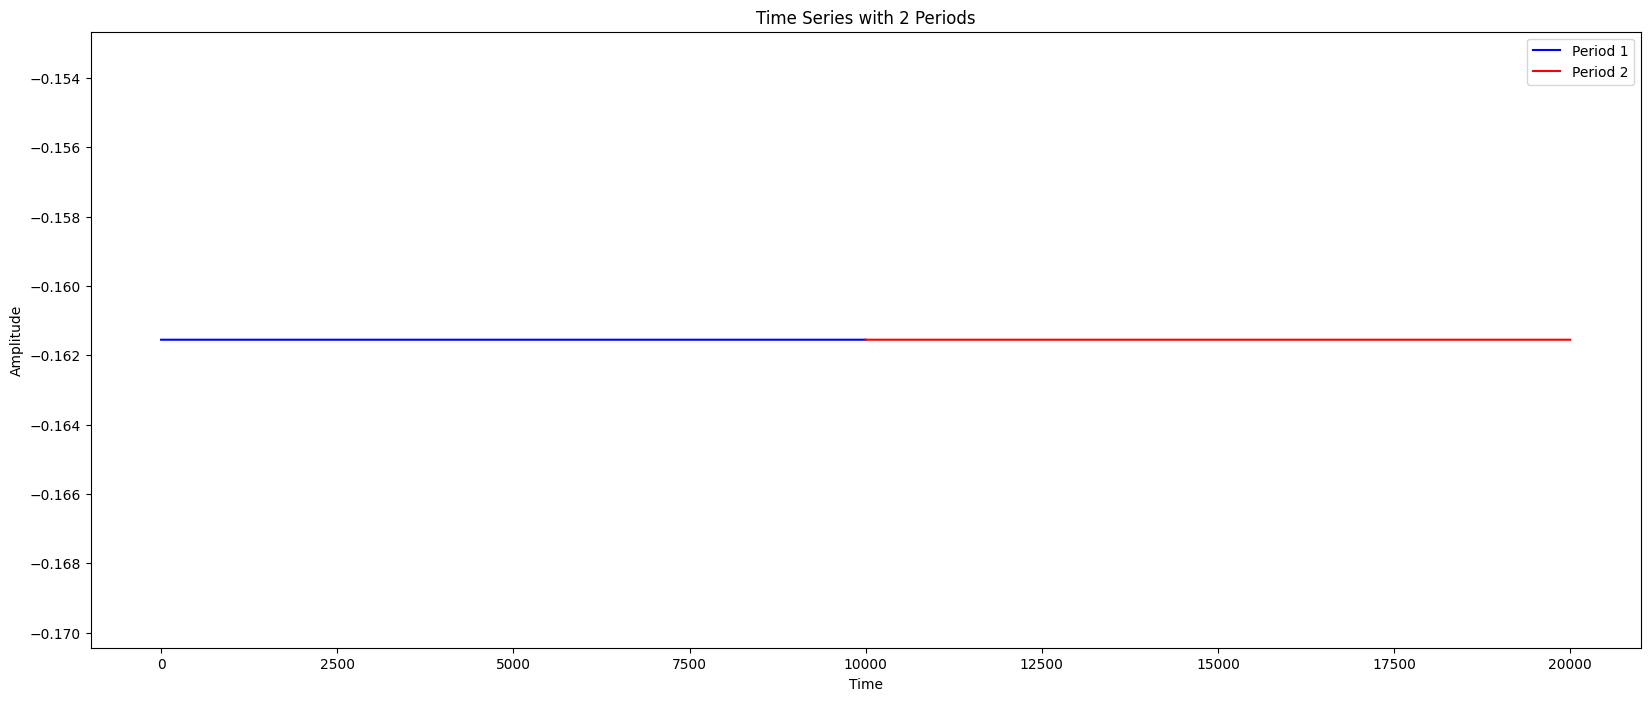

In [5]:
import numpy as np
from matplotlib import pyplot as plt

from anomaly_detection.visualize import plot_train_and_test
from anomaly_detection.visualize import plot_anomaly_events
from anomaly_detection.event import get_events_from_labels

kpi_num = SMD_dataset_loader.train.shape[1]
print("kpi_num: ", kpi_num)


for i in range(SMD_dataset_loader.train.shape[1]):
    train_series = SMD_dataset_loader.train[-10000:, i]
    test_series = SMD_dataset_loader.test[:10000, i]
    test_labels = SMD_dataset_loader.test_labels[:10000]
    events = get_events_from_labels(test_labels)
    x = np.arange(train_series.shape[0] + test_series.shape[0])

    # plot train data and test data
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(20, 8))

    # Plot the first period in blue
    ax.plot(x[:train_series.shape[0]], train_series,
            color='blue', label='Period 1')

    # Plot the second period in red
    ax.plot(x[train_series.shape[0]:], test_series,
            color='red', label='Period 2')

    # Add a legend, title, and axis labels
    ax.legend()
    ax.set_title(f'KPI {i}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')

    low = np.min(np.concatenate([train_series, test_series]))
    high = np.max(np.concatenate([train_series, test_series]))
    plot_anomaly_events(
        plt, events, train_series.shape[0], low=low-0.1, high=high+0.1)


In [3]:
kpi_num = 38

## Without Selection

In [7]:
from anomaly_detection.solvers.AnomalyTransformerSolver import AnomalyTransformerSolver

solver = AnomalyTransformerSolver({
    # hyperparameters
    'lr': 1e-4,
    'num_epochs': 10,
    'k': 3,
    'win_size': 100,
    'input_c': kpi_num,
    'output_c': kpi_num,

    # training settings
    'batch_size': 256,
    'patience': 3,

    # testing settings
    "anomaly_ratio": 2.0,

    # data settings
    'dataset': 'SMD',
    'scaler': 'standard',
    'model_save_path': './model_save/',
    'data_path': f'./dataset/SMD/',
    'output_dir': f'./output/SMD/',
    'model_name': 'AnomalyTransformer_SMD',

    "model_init_checkpoint": None,
})


config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 38, 'output_c': 38, 'batch_size': 256, 'patience': 3, 'anomaly_ratio': 2.0, 'dataset': 'SMD', 'scaler': 'standard', 'model_save_path': './model_save/', 'data_path': './dataset/SMD/', 'output_dir': './output/SMD/', 'model_name': 'AnomalyTransformer_SMD', 'model_init_checkpoint': None}
(708405, 38)


In [ ]:
solver.train()

In [8]:
solver.test()

======================TEST MODE======================


/home/xingjian/.local/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


anomaly events: 327 anomaly events hits: 194
origin positives: 16158 predicted events: 8009
anomaly_ratio:  2.0 threshold:  4.743228491861358e-05 accuracy:  0.9767913608130999
   precision    recall        f1
0   0.072101  0.950822  0.134037
1   0.651236  0.950822  0.773018
2   0.060557  0.593272  0.109896


## KPI Sensitivity Calculation

### Train Anomaly Detection Models

In [16]:
# split SMD dataset into datasets of different KPIs
import numpy as np
import os
single_kpi_data_path = "./dataset/SMD_single/"

SMD_dataset_loader = load_SMD()

for i in range(kpi_num):
    os.makedirs(single_kpi_data_path + str(i), exist_ok=True)    
    
    np.save(os.path.join(single_kpi_data_path, str(i), "train.npy"), SMD_dataset_loader.train[:, i:i+1])
    np.save(os.path.join(single_kpi_data_path, str(i), "test.npy"), SMD_dataset_loader.test[:, i:i+1])
    np.save(os.path.join(single_kpi_data_path, str(i), "labels.npy"), SMD_dataset_loader.test_labels)


(708405, 38)


In [18]:
for i in range(kpi_num):
    print(f"training anomaly detection model for KPI {i}")


    solver = AnomalyTransformerSolver({
        # hyperparameters
        'lr': 1e-4,
        'num_epochs': 10,
        'k': 3,
        'win_size': 100,
        'input_c': 1,
        'output_c': 1,

        # training settings
        'batch_size': 256,
        'patience': 3,

        # testing settings
        "anomaly_ratio": 2.0,

        # data settings
        'dataset': 'SMD',
        'scaler': 'standard',
        'model_save_path': './model_save/',
        'data_path': f'./dataset/SMD_single/{i}/',
        'output_dir': f'./output/SMD_single/{i}/',
        'model_name': f'AnomalyTransformer_SMD_single_{i}',

        "model_init_checkpoint": None,
    })

    solver.train()



config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 1, 'output_c': 1, 'batch_size': 256, 'patience': 3, 'anomaly_ratio': 2.0, 'dataset': 'SMD', 'scaler': 'standard', 'model_save_path': './model_save/', 'data_path': './dataset/SMD_single/0/', 'output_dir': './output/SMD_single/0/', 'model_name': 'AnomalyTransformer_SMD_single_0', 'model_init_checkpoint': None}
(708405, 1)
======================TRAIN MODE======================
	speed: 0.1786s/iter; left time: 4924.0425s
	speed: 0.1780s/iter; left time: 4888.8885s
	speed: 0.1785s/iter; left time: 4885.7904s
	speed: 0.1787s/iter; left time: 4874.6163s
	speed: 0.1790s/iter; left time: 4863.3096s
	speed: 0.1792s/iter; left time: 4850.0255s
	speed: 0.1795s/iter; left time: 4842.4769s
	speed: 0.1796s/iter; left time: 4825.9450s
	speed: 0.1799s/iter; left time: 4816.8352s
	speed: 0.1799s/iter; left time: 4798.5105s
	speed: 0.1799s/iter; left time: 4781.2800s
	speed: 0.1800s/iter; left time: 4763.4772s
	speed: 0.1800s/i

### Detection with trained models

### Sensitivity Calculation

## KPI Selection

## Anomaly Detection

# Cloud System KPI

## Fault Injection Information

## KPI Sensitivity Calculation

## KPI Selection

## Anomaly Detection